In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from generate_data import generate_Ls, generate_sylvester_data
from proximal_gradient_descent import (
    get_optimizer_oracles,
    proximal_accelerated_gradient,
    project_to_lower_with_positive_diag,
    warm_start
)
from plotting_utilities import get_metrics, patternify_Ls, one_example_prs
import scanpy as sc
import igraph as ig

# Prevent Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Make sure everything still works

In [2]:
np.random.seed(0)

# Let's generate a 50 x 50 matrix from our Cartesian LGAM model in which the
# ground truth graphs have only 10% nonzero elements.
dims = (50, 50)
sparsity = 0.1
Ls, L_patterns = generate_Ls(dims, sparsity=sparsity)
X = generate_sylvester_data(Ls, normalize=True, source_distribution=np.random.normal)

L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = 0.5e-6
objective, gradient, proximal = get_optimizer_oracles(X, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=5000,
    tol=1e-20
)

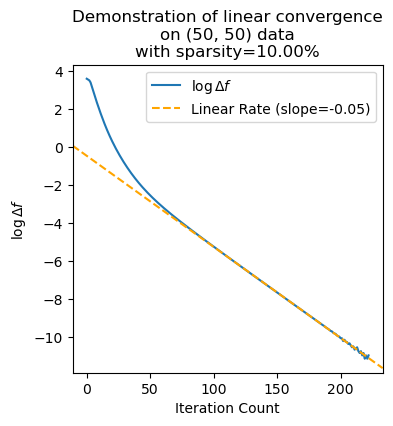

In [3]:
del_f = -np.array(eps)
iterations = np.arange(len(eps))

# Ignore iterations where the objective error increased
# (we use accelerated gradient descent so this will happen every now
# and then, which is annoying for taking the logarithm)
iterations = iterations[del_f > 0]
del_f = np.log10(del_f[del_f > 0])

# Fit a line through the data to demonstrate it really is linear
linear_data = iterations > 100
slope, intercept = np.polyfit(iterations[linear_data], del_f[linear_data], deg=1)

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(iterations, del_f, label=r"$\log\Delta f$")
ax.set_title(f"Demonstration of linear convergence\non {dims} data\nwith {sparsity=:.2%}")
ax.set_xlabel("Iteration Count")
ax.set_ylabel(rf"$\log\Delta f$")
ax.axline(xy1=(0, intercept), slope=slope, linestyle='--', color='orange', label=f'Linear Rate ({slope=:.2f})')
ax.legend()
pass

Run on real data

In [4]:
blob_data = sc.datasets.blobs(n_variables=50, n_observations=50, n_centers=5)
dataset = blob_data.X
dataset /= (dataset**2).sum()
dataset.shape

(50, 50)

In [5]:
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = 0.9e-5
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-20
)

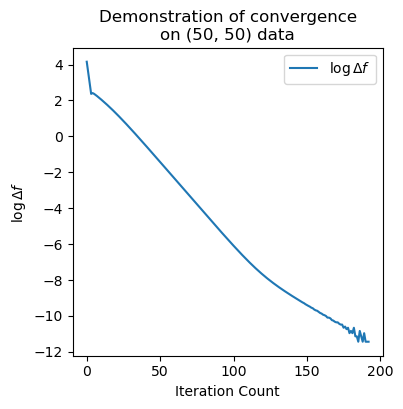

In [6]:
del_f = -np.array(eps)
iterations = np.arange(len(eps))

# Ignore iterations where the objective error increased
# (we use accelerated gradient descent so this will happen every now
# and then, which is annoying for taking the logarithm)
iterations = iterations[del_f > 0]
del_f = np.log10(del_f[del_f > 0])

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(iterations, del_f, label=r"$\log\Delta f$")
ax.set_title(f"Demonstration of convergence\non {dims} data")
ax.set_xlabel("Iteration Count")
ax.set_ylabel(rf"$\log\Delta f$")
ax.legend()
pass

In [7]:
((Ls[0] != 0).sum() - Ls[0].shape[0]) / (Ls[0].shape[0]**2 - Ls[0].shape[0]) * 2

np.float64(0.1836734693877551)

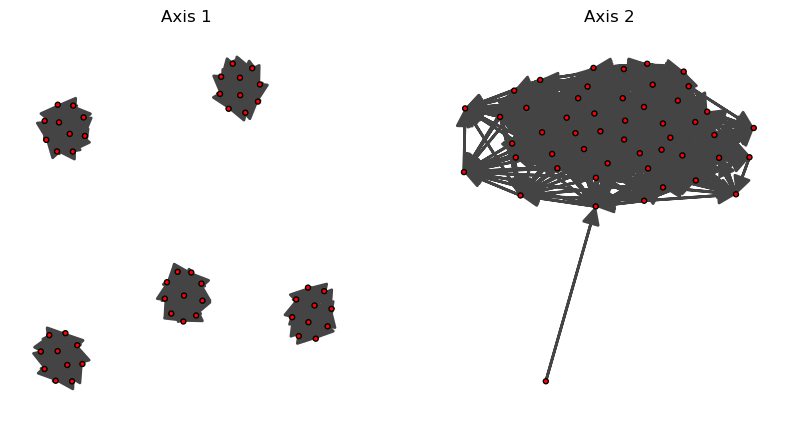

In [8]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

ig.plot(
    ig.Graph.Weighted_Adjacency(Ls[0]).simplify(),
    target=ax1,
    vertex_size=5
)
ig.plot(
    ig.Graph.Weighted_Adjacency(Ls[1]).simplify(),
    target=ax2,
    vertex_size=5
)

ax1.set_title("Axis 1")
ax2.set_title("Axis 2")
pass

In [9]:
krum_data = sc.datasets.krumsiek11()
krum = krum_data.X
krum /= (krum**2).sum()
krum_data

/Users/baileyandrew/mambaforge/envs/Cartesian-LGAM/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type'
    uns: 'iroot', 'highlights'

In [10]:
dims = krum.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = 0.6e-3 #0.5e-3 ~1.9%
objective, gradient, proximal = get_optimizer_oracles(krum, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

In [11]:
((Ls[0] != 0).sum() - Ls[0].shape[0]) / (Ls[0].shape[0]**2 - Ls[0].shape[0]) * 2

np.float64(0.0290835289514867)

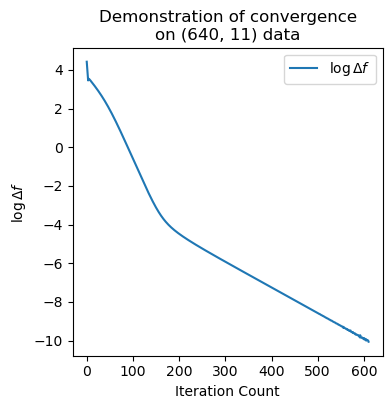

In [12]:
del_f = -np.array(eps)
iterations = np.arange(len(eps))

# Ignore iterations where the objective error increased
# (we use accelerated gradient descent so this will happen every now
# and then, which is annoying for taking the logarithm)
iterations = iterations[del_f > 0]
del_f = np.log10(del_f[del_f > 0])

fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(iterations, del_f, label=r"$\log\Delta f$")
ax.set_title(f"Demonstration of convergence\non {dims} data")
ax.set_xlabel("Iteration Count")
ax.set_ylabel(rf"$\log\Delta f$")
ax.legend()
pass

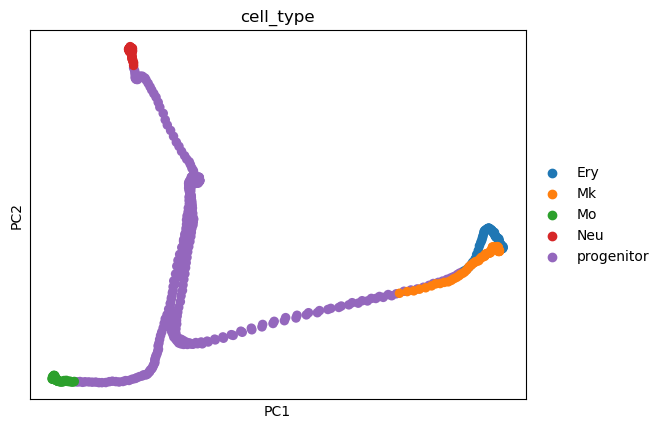

In [13]:
sc.pp.pca(krum_data)
sc.pl.pca(krum_data, color='cell_type')

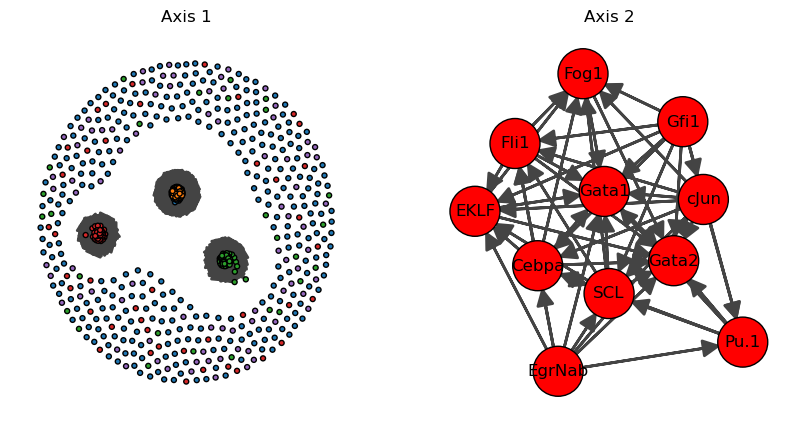

In [14]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

cell_graph = ig.Graph.Weighted_Adjacency(Ls[0]).simplify()
cell_types = krum_data.obs['cell_type']
type_to_color = {ctype: krum_data.uns['cell_type_colors'][i % len(krum_data.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
cell_graph.vs["edge_color"] = cell_graph.vs["color"]

gene_graph = ig.Graph.Weighted_Adjacency(Ls[1]).simplify()
gene_graph.vs["label"] = krum_data.var_names

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5
)
ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50
)

ax1.set_title("Axis 1")
ax2.set_title("Axis 2")
pass

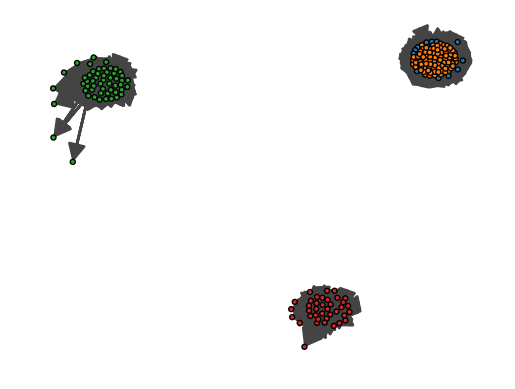

In [15]:
non_singletons = [v.index for v in cell_graph.vs if cell_graph.degree(v) > 0]
g_no_singletons = cell_graph.induced_subgraph(non_singletons)

fig, ax = plt.subplots()
ig.plot(
    g_no_singletons,
    target=ax,
    vertex_size=5
)

In [16]:
Ls_cells = [L.copy() for L in Ls]

In [17]:
dims = krum.shape
L_init = [L.copy() for L in Ls_cells]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = 0.6e-2 #0.5e-3 ~1.9%
objective, gradient, proximal = get_optimizer_oracles(krum, frobreg=frobreg, glassoregs=glassoreg)

Ls_genes, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

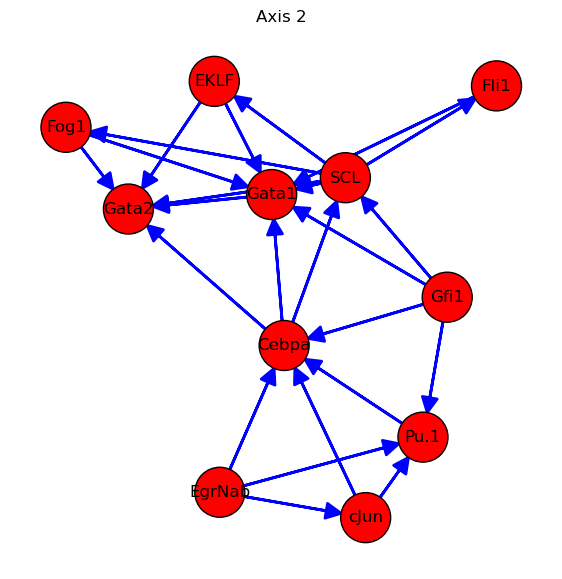

In [18]:
# It'll take a couple seconds to draw this graph.
fig, ax2 = plt.subplots(figsize=(7, 7), ncols=1)


gene_graph = ig.Graph.Weighted_Adjacency(Ls_genes[1] - np.diag(np.diag(Ls_genes[1])))
gene_graph.vs["label"] = krum_data.var_names
gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]

ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    edge_color=gene_graph.es["color"],
)

ax1.set_title("Axis 1")
ax2.set_title("Axis 2")
pass

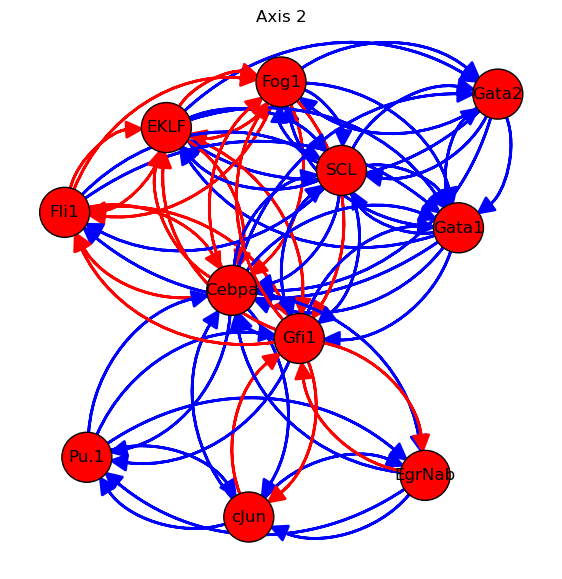

In [19]:
# It'll take a couple seconds to draw this graph.
fig, ax2 = plt.subplots(figsize=(7, 7), ncols=1)

Psi = Ls_genes[1] @ Ls_genes[1].T
np.fill_diagonal(Psi, 0)
gene_graph = ig.Graph.Weighted_Adjacency(Psi)
gene_graph.vs["label"] = krum_data.var_names
gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]

ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    edge_color=gene_graph.es["color"],
)

ax1.set_title("Axis 1")
ax2.set_title("Axis 2")
pass

In [114]:
ordered_krum = krum_data[:, ["Gata1", "Gata2", "SCL", "Fog1", "EKLF", "Fli1", "Cebpa", "Pu.1", "cJun", "EgrNab", "Gfi1"]]

r1 = 1
r2 = 0
r3 = -1
r4 = -2

gene_layout = [
    (0, r2), (1, r1), (1, r3), (-1, r1), (-0.5, r4), (-2.5, r4), (4.5, r1), (2, r2), (2.5, r3), (3.5, r4), (5.5, r4)
]

In [ ]:
dims = ordered_krum.X.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = 0.1e-1 #0.1e-1
objective, gradient, proximal = get_optimizer_oracles(ordered_krum.X, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

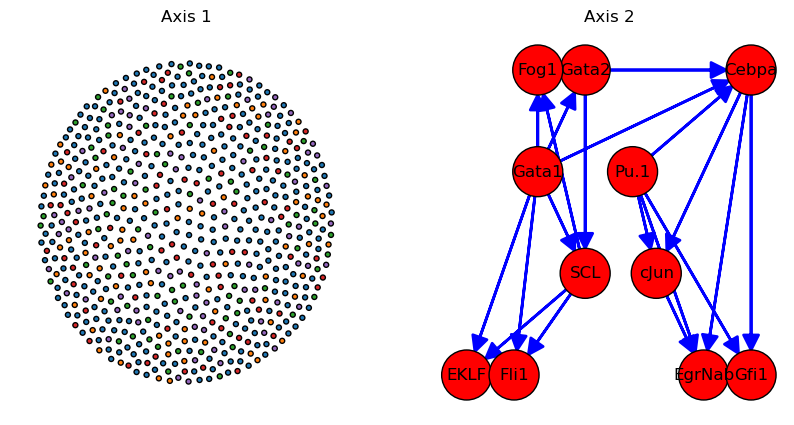

In [72]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

# Must transpose - convention in iGraph is that i -> j, whereas with LGAM It's j -> i
cell_graph = ig.Graph.Weighted_Adjacency(Ls[0].T).simplify()
cell_types = ordered_krum.obs['cell_type']
type_to_color = {ctype: ordered_krum.uns['cell_type_colors'][i % len(ordered_krum.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
cell_graph.vs["edge_color"] = cell_graph.vs["color"]

gene_graph = ig.Graph.Weighted_Adjacency(Ls[1].T - np.diag(np.diag(Ls[1])))
gene_graph.vs["label"] = ordered_krum.var_names
gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5
)
ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Axis 1")
ax2.set_title("Axis 2")
pass

Negative regulation due to zero inflation?

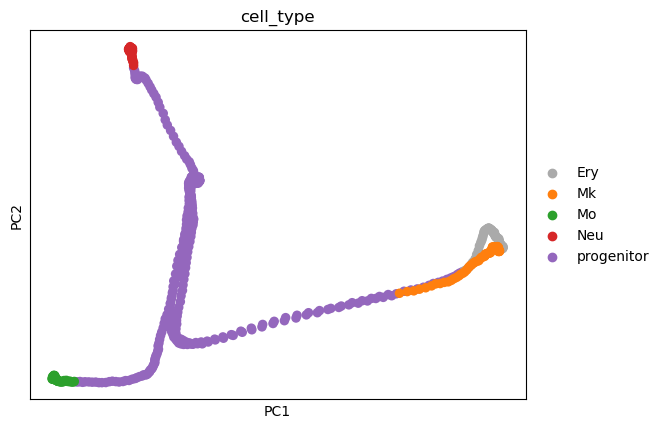

In [150]:
ordered_krum.uns['cell_type_colors'][0] = '#aaaaaa'
sc.pl.pca(ordered_krum, color='cell_type')

In [122]:
dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = [3e-2, 1.5e0] # [3e-2, 1.5e0]
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


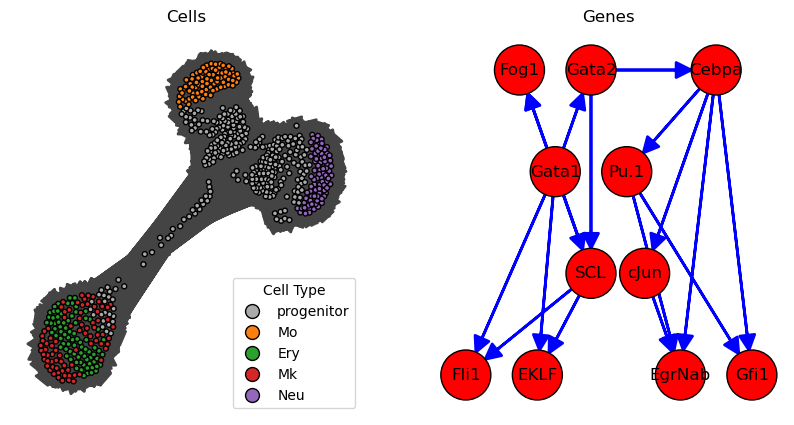

In [162]:
# It'll take a couple seconds to draw this graph.
import matplotlib.lines
import random

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

# Must transpose - convention in iGraph is that i -> j, whereas with LGAM It's j -> i
cell_graph = ig.Graph.Weighted_Adjacency(Ls[0].T - np.diag(np.diag(Ls[0])))
cell_types = ordered_krum.obs['cell_type']
type_to_color = {ctype: ordered_krum.uns['cell_type_colors'][i % len(ordered_krum.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
#cell_graph.vs["edge_color"] = cell_graph.vs["color"]
#cell_graph.es["color"] = ['red' if w > 0 else 'blue' for w in cell_graph.es["weight"]]

random.seed(0)
cell_layout = cell_graph.layout(layout='auto')

gene_graph = ig.Graph.Weighted_Adjacency(Ls[1].T - np.diag(np.diag(Ls[1])))
gene_graph.vs["label"] = ordered_krum.var_names
gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5,
    layout=cell_layout
)
ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Cells")
ax2.set_title("Genes")

# Add legend
# Extract colors and labels
colors = ordered_krum.uns['cell_type_colors']
labels = ordered_krum.obs['cell_type'].unique()

# Build legend handles
handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=color, markersize=10, label=label)
    for label, color in zip(labels, colors)
]
ax1.legend(handles=handles, title='Cell Type', loc='lower right')

pass

In [176]:
ordered_krum.obsp["cell_graph"] = np.abs(Ls[0].T - np.diag(np.diag(Ls[0])))
ordered_krum.varp["gene_graph"] = np.abs(Ls[1].T - np.diag(np.diag(Ls[1])))

sc.tl.leiden(ordered_krum, obsp="cell_graph", key_added="leiden_clgam", resolution=3)
ordered_krum

AnnData object with n_obs × n_vars = 640 × 11
    obs: 'cell_type', 'leiden_clgam'
    uns: 'iroot', 'highlights', 'pca', 'cell_type_colors', 'leiden_clgam', 'leiden_clgam_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'cell_graph'
    varp: 'gene_graph'

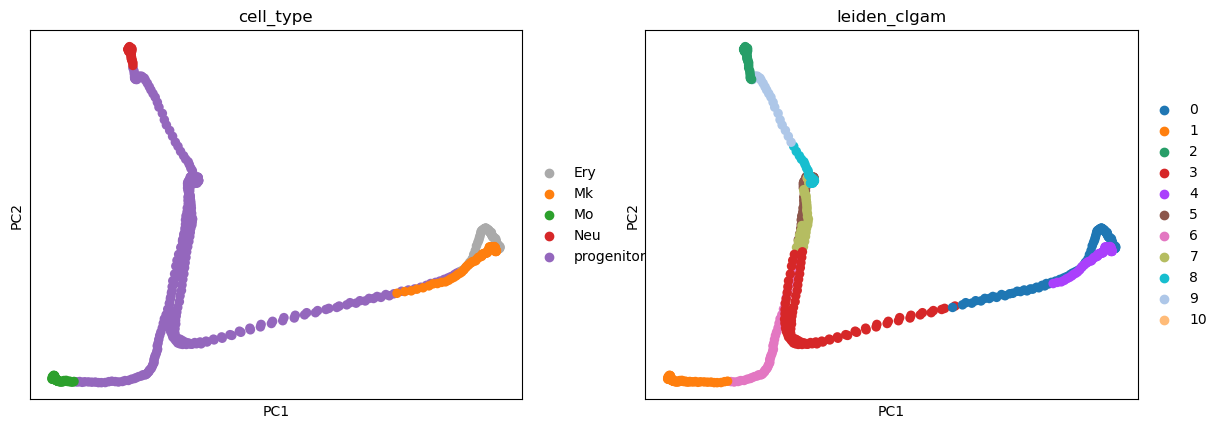

In [177]:
sc.pl.pca(ordered_krum, color=["cell_type", "leiden_clgam"])

In [196]:
ordered_krum.obs["unique_id"] = np.arange(ordered_krum.shape[0])

In [180]:
overlaps = np.zeros((
    len(ordered_krum.obs["cell_type"].unique()),
    len(ordered_krum.obs["leiden_clgam"].unique())
))
for i, cell_type in enumerate(ordered_krum.obs["cell_type"].unique()):
    for j, leiden_result in enumerate(ordered_krum.obs["leiden_clgam"].unique()):
        subset = ordered_krum[
            (ordered_krum.obs["cell_type"] == cell_type)
            & (ordered_krum.obs["leiden_clgam"] == leiden_result)
        ]
        overlaps[i, j] = subset.shape[0]

overlaps

array([[50., 49., 13., 34., 80., 28.,  0.,  1., 34., 23.,  8.],
       [ 0.,  0., 80.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., 80.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  7., 73.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 80.]])

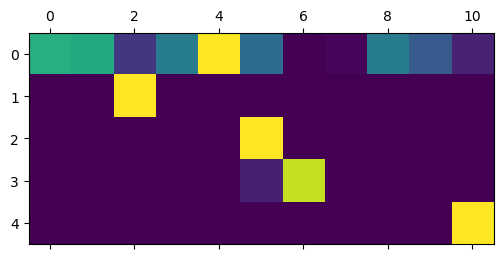

In [181]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(overlaps)

array([[0.15625   , 0.153125  , 0.0325    , 0.10625   , 0.25      ,
        0.06879607, 0.        , 0.003125  , 0.10625   , 0.071875  ,
        0.02      ],
       [0.        , 0.        , 0.86021505, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.69565217, 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.03723404, 0.9125    , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.90909091]])

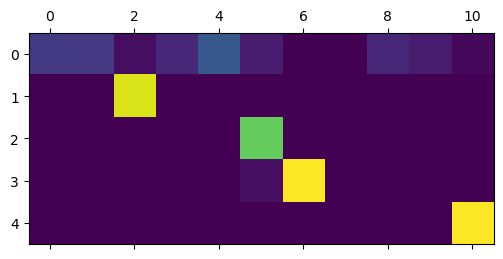

In [198]:
jaccard = np.zeros((
    len(ordered_krum.obs["cell_type"].unique()),
    len(ordered_krum.obs["leiden_clgam"].unique())
))
for i, cell_type in enumerate(ordered_krum.obs["cell_type"].unique()):
    for j, leiden_result in enumerate(ordered_krum.obs["leiden_clgam"].unique()):
        subset_1 = set(ordered_krum[(ordered_krum.obs["cell_type"] == cell_type)].obs["unique_id"])
        subset_2 = set(ordered_krum[(ordered_krum.obs["leiden_clgam"] == leiden_result)].obs["unique_id"])
        jaccard[i, j] = len(subset_1 & subset_2) / len(subset_1 | subset_2)

fig, ax = plt.subplots(figsize=(6, 6))
ax.matshow(jaccard)
jaccard

In [205]:
from sklearn.metrics import homogeneity_score, completeness_score, adjusted_mutual_info_score, adjusted_rand_score

In [206]:
print(homogeneity_score(ordered_krum.obs['cell_type'], ordered_krum.obs['leiden_clgam']))
print(completeness_score(ordered_krum.obs['cell_type'], ordered_krum.obs['leiden_clgam']))
print(adjusted_mutual_info_score(ordered_krum.obs['cell_type'], ordered_krum.obs['leiden_clgam']))
print(adjusted_rand_score(ordered_krum.obs['cell_type'], ordered_krum.obs['leiden_clgam']))

0.8279865419133471
0.5202052815694145
0.632536949432783
0.32972611390842566


In [213]:
resolutions = [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5]
num_res = len(resolutions)
results = np.zeros((num_res, 4))

for i, resolution in enumerate(resolutions):
    sc.tl.leiden(ordered_krum, obsp="cell_graph", key_added="temp_leiden", resolution=resolution)
    results[i, 0] = homogeneity_score(ordered_krum.obs['cell_type'], ordered_krum.obs['temp_leiden'])
    results[i, 1] = completeness_score(ordered_krum.obs['cell_type'], ordered_krum.obs['temp_leiden'])
    results[i, 2] = adjusted_mutual_info_score(ordered_krum.obs['cell_type'], ordered_krum.obs['temp_leiden'])
    results[i, 3] = adjusted_rand_score(ordered_krum.obs['cell_type'], ordered_krum.obs['temp_leiden'])

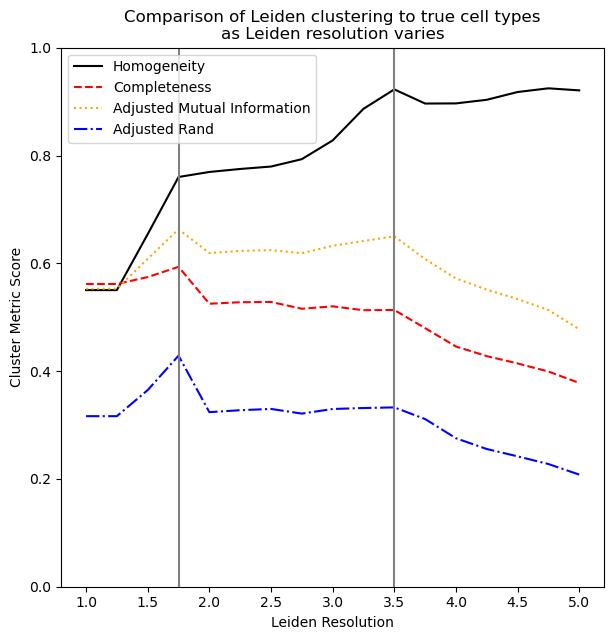

In [223]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(resolutions, results[:, 0], color='black', linestyle='-', label="Homogeneity")
ax.plot(resolutions, results[:, 1], color='red', linestyle='--', label="Completeness")
ax.plot(resolutions, results[:, 2], color='orange', linestyle=':', label="Adjusted Mutual Information")
ax.plot(resolutions, results[:, 3], color='blue', linestyle='-.', label="Adjusted Rand")

ax.legend(loc="upper left")
ax.set_xlabel("Leiden Resolution")
ax.set_ylabel("Cluster Metric Score")
ax.set_title("Comparison of Leiden clustering to true cell types\nas Leiden resolution varies")
ax.set_ylim([0, 1])

ax.axvline(1.75, color='grey')
ax.axvline(3.5, color='grey')

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3597853804.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


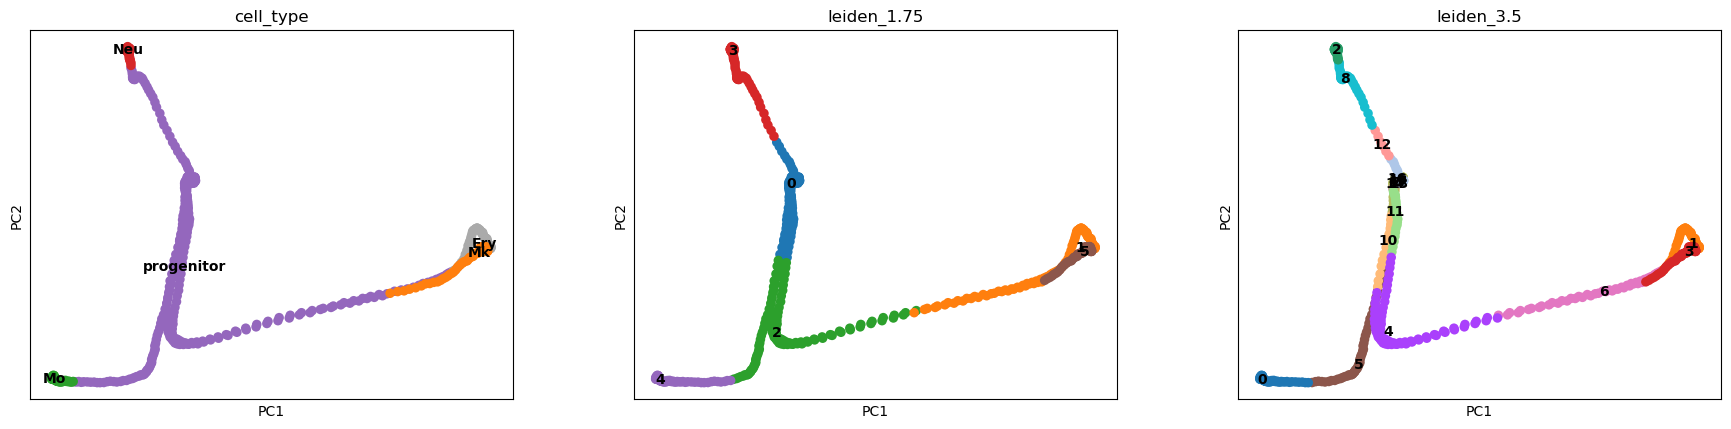

In [ ]:
sc.tl.leiden(ordered_krum, obsp="cell_graph", key_added="leiden_1.75", resolution=1.75)
sc.tl.leiden(ordered_krum, obsp="cell_graph", key_added="leiden_3.5", resolution=3.5)
fig = sc.pl.pca(ordered_krum, color=["cell_type", "leiden_1.75", "leiden_3.5"], return_fig=True, legend_loc="on data")
fig.tight_layout()

In [292]:
true_graph = np.tril(np.array([
    # 'Gata1', 'Gata2', 'SCL', 'Fog1', 'EKLF', 'Fli1', 'Cebpa', 'Pu.1', 'cJun', 'EgrNab', 'Gfi1'
    [0,            1,      1,      1,     1,      1,       0,       1,      0,      0,       0], # Gata1
    [1,            0,      0,      1,     0,      0,       0,       1,      0,      0,       0], # Gata2
    [1,            0,      0,      0,     0,      0,       0,       1,      0,      0,       0], # SCL
    [1,            1,      0,      0,     0,      0,       0,       0,      0,      0,       0], # Fog1
    [1,            0,      0,      0,     0,      1,       0,       0,      0,      0,       0], # EKLF
    [1,            0,      0,      0,     1,      0,       0,       0,      0,      0,       0], # Fli1
    [0,            0,      0,      0,     0,      0,       0,       1,      0,      0,       1], # Cebpa
    [1,            1,      1,      0,     0,      0,       1,       0,      1,      1,       1], # Pu.1
    [0,            0,      0,      0,     0,      0,       0,       1,      0,      1,       0], # cJun
    [0,            0,      0,      0,     0,      0,       0,       1,      1,      0,       1], # EgrNab
    [0,            0,      0,      0,     0,      0,       1,       1,      0,      1,       0], # Gfi1
])) != 0
flat_true_graph = true_graph.reshape(-1)

estim_graph = (ordered_krum.varp["gene_graph"] != 0).reshape(-1)
(estim_graph & flat_true_graph).sum() / (estim_graph | flat_true_graph).sum()

np.float64(0.0)

In [258]:
dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoregs = [
    (3e0, 1.5e2),
    (1e0, 0.5e2),
    (3e-1, 1.5e1),
    (1e-1, 0.5e1),
    (3e-2, 1.5e0),
    (1e-2, 0.5e0),
    (3e-3, 1.5e-1),
    (1e-3, 0.5e-1),
    (3e-4, 1.5e-2),
] # [3e-2, 1.5e0] is nice
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls_, diagnostics = warm_start(
    ordered_krum.X,
    L_init=L_init,
    glassoregs = glassoregs,
    frobreg=frobreg,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    verbose=True
)

L1 Param: (3.0, 150.0)
L1 Param: (1.0, 50.0)
L1 Param: (0.3, 15.0)


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: (0.1, 5.0)
L1 Param: (0.03, 1.5)
L1 Param: (0.01, 0.5)
L1 Param: (0.003, 0.15)
L1 Param: (0.001, 0.05)
L1 Param: (0.0003, 0.015)


In [272]:
dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))

cell_range = np.logspace(0, -4, 20)
gene_range = np.logspace(2, -2, 20)

glassoregs = [
    (1e-2, x) for x in gene_range
] # [3e-2, 1.5e0] is nice
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls_, diagnostics = warm_start(
    ordered_krum.X,
    L_init=L_init,
    glassoregs = glassoregs,
    frobreg=frobreg,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    verbose=True
)

L1 Param: (0.01, np.float64(100.0))


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: (0.01, np.float64(61.58482110660264))
L1 Param: (0.01, np.float64(37.926901907322495))
L1 Param: (0.01, np.float64(23.357214690901223))
L1 Param: (0.01, np.float64(14.38449888287663))
L1 Param: (0.01, np.float64(8.858667904100827))
L1 Param: (0.01, np.float64(5.45559478116852))
L1 Param: (0.01, np.float64(3.3598182862837827))
L1 Param: (0.01, np.float64(2.06913808111479))
L1 Param: (0.01, np.float64(1.2742749857031341))
L1 Param: (0.01, np.float64(0.7847599703514615))
L1 Param: (0.01, np.float64(0.4832930238571752))
L1 Param: (0.01, np.float64(0.2976351441631319))
L1 Param: (0.01, np.float64(0.18329807108324375))
L1 Param: (0.01, np.float64(0.11288378916846895))
L1 Param: (0.01, np.float64(0.06951927961775606))
L1 Param: (0.01, np.float64(0.04281332398719396))
L1 Param: (0.01, np.float64(0.026366508987303607))
L1 Param: (0.01, np.float64(0.016237767391887224))
L1 Param: (0.01, np.float64(0.01))


In [278]:
dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

Ls_ = []
frobreg = 1/np.prod(dims)**(1/len(dims))
for idx, gene_glassoreg in enumerate(np.logspace(2, -2, 20)):
    glassoreg = [3e-2, gene_glassoreg] # [3e-2, 1.5e0]
    objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

    print(f"{idx}: {gene_glassoreg:.2e}")

    Ls_.append(proximal_accelerated_gradient(
        f=objective,
        del_f=gradient,
        prox=proximal,
        P=project_to_lower_with_positive_diag,
        Ls=L_init,
        mu=0.2,
        init_alpha=1,
        tau=0.5,
        beta=0.0001,
        max_iter=1000,
        tol=1e-10
    )[0])

0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


1: 6.16e+01
2: 3.79e+01
3: 2.34e+01
4: 1.44e+01
5: 8.86e+00
6: 5.46e+00
7: 3.36e+00
8: 2.07e+00
9: 1.27e+00
10: 7.85e-01
11: 4.83e-01
12: 2.98e-01
13: 1.83e-01
14: 1.13e-01
15: 6.95e-02
16: 4.28e-02
17: 2.64e-02
18: 1.62e-02
19: 1.00e-02


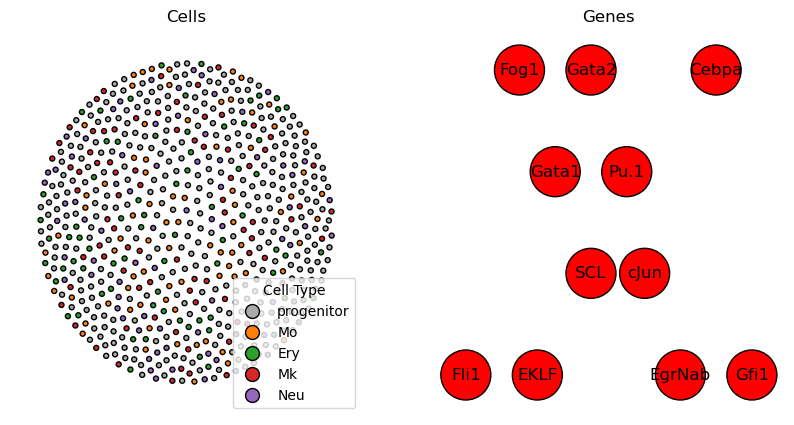

In [257]:
# It'll take a couple seconds to draw this graph.
import matplotlib.lines
import random

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

# Must transpose - convention in iGraph is that i -> j, whereas with LGAM It's j -> i
cell_graph = ig.Graph.Weighted_Adjacency(Ls_[0][0].T - np.diag(np.diag(Ls_[0][0])))
cell_types = ordered_krum.obs['cell_type']
type_to_color = {ctype: ordered_krum.uns['cell_type_colors'][i % len(ordered_krum.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
#cell_graph.vs["edge_color"] = cell_graph.vs["color"]
#cell_graph.es["color"] = ['red' if w > 0 else 'blue' for w in cell_graph.es["weight"]]

random.seed(0)
cell_layout = cell_graph.layout(layout='auto')

gene_graph = ig.Graph.Weighted_Adjacency(Ls_[0][1].T - np.diag(np.diag(Ls_[0][1])))
gene_graph.vs["label"] = ordered_krum.var_names
gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5,
    layout=cell_layout
)
ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Cells")
ax2.set_title("Genes")

# Add legend
# Extract colors and labels
colors = ordered_krum.uns['cell_type_colors']
labels = ordered_krum.obs['cell_type'].unique()

# Build legend handles
handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=color, markersize=10, label=label)
    for label, color in zip(labels, colors)
]
ax1.legend(handles=handles, title='Cell Type', loc='lower right')

pass

Text(0.5, 1.0, 'Performance on gene graph')

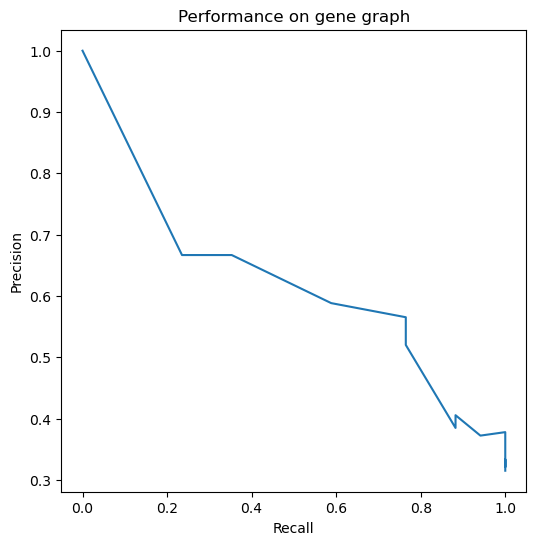

In [295]:
def precision(true, pred):
    if pred.sum() == 0:
        return 1
    return (pred & true).sum() / pred.sum()

def recall(true, pred):
    if true.sum() == 0:
        return 1
    return (pred & true).sum() / true.sum()

precs = []
reccs = []
for Lss in Ls_:
    genes = (Lss[1] - np.diag(np.diag(Lss[1]))) != 0
    prec = precision(true_graph, genes)
    recc = recall(true_graph, genes)
    precs.append(prec)
    reccs.append(recc)

reccs = np.array(reccs)
idxs = np.argsort(reccs)
reccs = reccs[idxs]
precs = np.array(precs)[idxs]

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(reccs, precs)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Performance on gene graph")

In [297]:
from sklearn.metrics import auc

auc(reccs, precs)

np.float64(0.6220558597547692)

In [299]:
def get_aupr(Ls_):
    precs = []
    reccs = []
    for Lss in Ls_:
        genes = (Lss[1] - np.diag(np.diag(Lss[1]))) != 0
        prec = precision(true_graph, genes)
        recc = recall(true_graph, genes)
        precs.append(prec)
        reccs.append(recc)

    # L1 penalty for graphical models not necessarily monotonically sparse
    reccs = np.array(reccs)
    idxs = np.argsort(reccs)
    reccs = reccs[idxs]
    precs = np.array(precs)[idxs]
    
    return auc(reccs, precs)

get_aupr(Ls_)

np.float64(0.6220558597547692)

In [301]:
dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))

aupr_results = []
for cidx, cell_glassoreg in enumerate(np.logspace(0, -4, 20)):
    Ls_ = []
    print(f"{cidx}: {cell_glassoreg:.2e}")
    for gidx, gene_glassoreg in enumerate(np.logspace(2, -2, 20)):
        glassoreg = [cell_glassoreg, gene_glassoreg] # [3e-2, 1.5e0]
        objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

        print(f"\t{gidx}: {gene_glassoreg:.2e}")

        Ls_.append(proximal_accelerated_gradient(
            f=objective,
            del_f=gradient,
            prox=proximal,
            P=project_to_lower_with_positive_diag,
            Ls=L_init,
            mu=0.2,
            init_alpha=1,
            tau=0.5,
            beta=0.0001,
            max_iter=1000,
            tol=1e-10
        )[0])

    aupr_result = get_aupr(Ls_)
    aupr_results.append(aupr_result)
    print(aupr_result)

    

0: 1.00e+00
	0: 1.00e+02
	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.5342081916162441
1: 6.16e-01
	0: 1.00e+02
	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.5322385458349488
2: 3.79e-01
	0: 1.00e+02
	1: 6.16e+01


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.5344982486418473
3: 2.34e-01
	0: 1.00e+02
	1: 6.16e+01


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.5539584734477406
4: 1.44e-01
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.5207694338445292
5: 8.86e-02
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.5706892398107568
6: 5.46e-02
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.5847869716733052
7: 3.36e-02
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.47510280826844287
8: 2.07e-02
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.5497704789959853
9: 1.27e-02
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.59579653232904
10: 7.85e-03
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.6051533831061467
11: 4.83e-03
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.5945729371966195
12: 2.98e-03
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.5937108517476131
13: 1.83e-03
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.5827557582747894
14: 1.13e-03
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.5670136704507429
15: 6.95e-04
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.6282565849979767
16: 4.28e-04
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.5567896740042069
17: 2.64e-04
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.6032360097762575
18: 1.62e-04
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.6249307258788682
19: 1.00e-04
	0: 1.00e+02


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01
	5: 8.86e+00
	6: 5.46e+00
	7: 3.36e+00
	8: 2.07e+00
	9: 1.27e+00
	10: 7.85e-01
	11: 4.83e-01
	12: 2.98e-01
	13: 1.83e-01
	14: 1.13e-01
	15: 6.95e-02
	16: 4.28e-02
	17: 2.64e-02
	18: 1.62e-02
	19: 1.00e-02
0.5416992293236104


In [302]:
aupr_results

[np.float64(0.5342081916162441),
 np.float64(0.5322385458349488),
 np.float64(0.5344982486418473),
 np.float64(0.5539584734477406),
 np.float64(0.5207694338445292),
 np.float64(0.5706892398107568),
 np.float64(0.5847869716733052),
 np.float64(0.47510280826844287),
 np.float64(0.5497704789959853),
 np.float64(0.59579653232904),
 np.float64(0.6051533831061467),
 np.float64(0.5945729371966195),
 np.float64(0.5937108517476131),
 np.float64(0.5827557582747894),
 np.float64(0.5670136704507429),
 np.float64(0.6282565849979767),
 np.float64(0.5567896740042069),
 np.float64(0.6032360097762575),
 np.float64(0.6249307258788682),
 np.float64(0.5416992293236104)]

Text(0.5, 1.0, 'Performance of the gene graph as we increase cell graph sparsity')

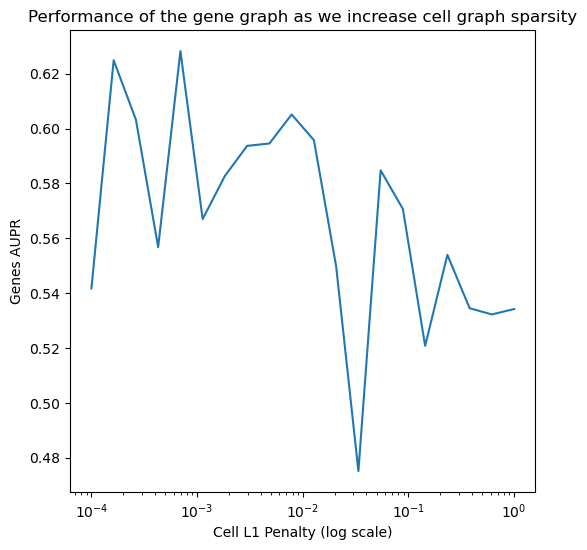

In [304]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(np.logspace(0, -4, 20), aupr_results)
ax.set_xscale('log')
ax.set_xlabel("Cell L1 Penalty (log scale)")
ax.set_ylabel("Genes AUPR")
ax.set_title("Performance of the gene graph as we increase cell graph sparsity")

In [338]:
dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))

cell_glassoreg = 1.62e-4
Ls_ = []
for gidx, gene_glassoreg in enumerate(np.logspace(2, -2, 20)):
    glassoreg = [cell_glassoreg, gene_glassoreg] # [3e-2, 1.5e0]
    objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

    print(f"\t{gidx}: {gene_glassoreg:.2e}")

    Ls_.append(proximal_accelerated_gradient(
        f=objective,
        del_f=gradient,
        prox=proximal,
        P=project_to_lower_with_positive_diag,
        Ls=L_init,
        mu=0.2,
        init_alpha=1,
        tau=0.5,
        beta=0.0001,
        max_iter=1000,
        tol=1e-10
    )[0])

get_aupr(Ls_)

	0: 1.00e+02
	1: 6.16e+01
	2: 3.79e+01
	3: 2.34e+01
	4: 1.44e+01


KeyboardInterrupt: 

In [347]:
dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))

cell_glassoreg = 1.62e-4
Ls_ = []
gene_glassoregs = np.logspace(2, -2, 20)
glassoregs = [(cell_glassoreg, gene_glassoreg) for gene_glassoreg in gene_glassoregs][::-1] # [3e-2, 1.5e0]

Ls_, diagnostics = warm_start(
    dataset,
    L_init=L_init,
    glassoregs=glassoregs,
    frobreg=frobreg,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-5,
    verbose=True
)

get_aupr(Ls_)

L1 Param: (0.000162, np.float64(0.01))


KeyboardInterrupt: 

In [360]:
dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))

cell_range = np.logspace(0, -4, 100)
gene_range = np.logspace(1, -2, 100)

glassoregs = [
    (1e-2, x) for x in gene_range
] # [3e-2, 1.5e0] is nice
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls_, diagnostics = warm_start(
    ordered_krum.X,
    L_init=L_init,
    glassoregs = glassoregs,
    frobreg=frobreg,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    verbose=True
)

L1 Param: (0.01, np.float64(10.0))
L1 Param: (0.01, np.float64(9.326033468832199))
L1 Param: (0.01, np.float64(8.697490026177835))
L1 Param: (0.01, np.float64(8.11130830789687))
L1 Param: (0.01, np.float64(7.564633275546289))
L1 Param: (0.01, np.float64(7.054802310718643))
L1 Param: (0.01, np.float64(6.579332246575679))
L1 Param: (0.01, np.float64(6.1359072734131725))
L1 Param: (0.01, np.float64(5.722367659350217))
L1 Param: (0.01, np.float64(5.3366992312063095))
L1 Param: (0.01, np.float64(4.977023564332112))
L1 Param: (0.01, np.float64(4.641588833612778))
L1 Param: (0.01, np.float64(4.328761281083058))
L1 Param: (0.01, np.float64(4.0370172585965545))
L1 Param: (0.01, np.float64(3.7649358067924674))
L1 Param: (0.01, np.float64(3.511191734215131))
L1 Param: (0.01, np.float64(3.2745491628777286))
L1 Param: (0.01, np.float64(3.0538555088334154))
L1 Param: (0.01, np.float64(2.848035868435802))
L1 Param: (0.01, np.float64(2.656087782946686))
L1 Param: (0.01, np.float64(2.4770763559917106))

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3093877018.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return 2 / (1 / precision(true, pred) + 1 / recall(true, pred))
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3093877018.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (TP * TN - FP * FN) / np.sqrt(


[(np.float64(1.0), np.float64(0.0)), (np.float64(1.0), np.float64(0.0)), (np.float64(1.0), np.float64(0.0)), (np.float64(1.0), np.float64(0.0)), (np.float64(1.0), np.float64(0.0)), (np.float64(1.0), np.float64(0.0)), (np.float64(1.0), np.float64(0.0)), (np.float64(1.0), np.float64(0.0)), (np.float64(1.0), np.float64(0.0)), (np.float64(0.6428571428571429), np.float64(0.5294117647058824)), (np.float64(0.5294117647058824), np.float64(0.5294117647058824)), (np.float64(0.5), np.float64(0.5294117647058824)), (np.float64(0.625), np.float64(0.5882352941176471)), (np.float64(0.5263157894736842), np.float64(0.5882352941176471)), (np.float64(0.6111111111111112), np.float64(0.6470588235294118)), (np.float64(0.55), np.float64(0.6470588235294118)), (np.float64(0.6111111111111112), np.float64(0.6470588235294118)), (np.float64(0.5909090909090909), np.float64(0.7647058823529411)), (np.float64(0.5), np.float64(0.7647058823529411)), (np.float64(0.5), np.float64(0.7647058823529411)), (np.float64(0.4814814

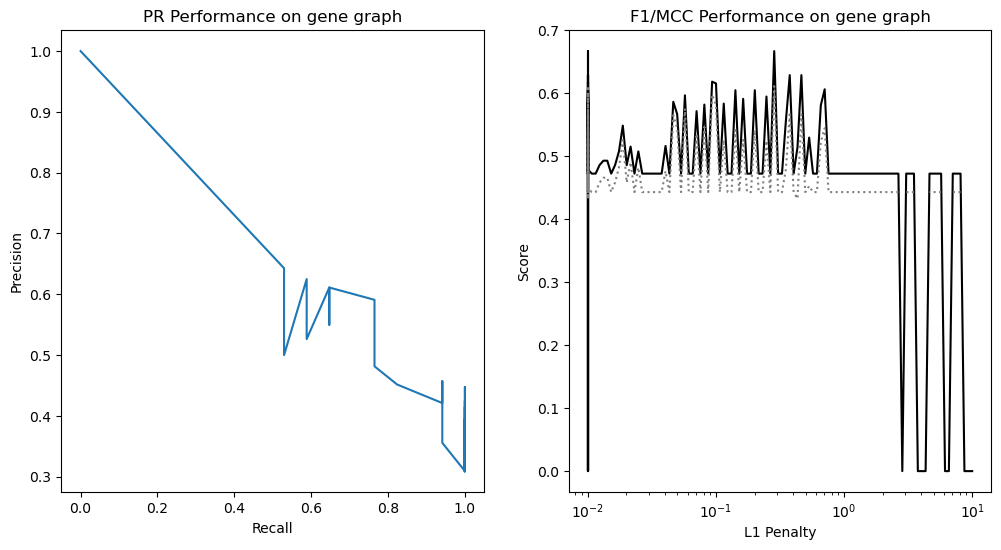

In [366]:
def precision(true, pred):
    if pred.sum() == 0:
        return 1
    return (pred & true).sum() / pred.sum()

def recall(true, pred):
    if true.sum() == 0:
        return 1
    return (pred & true).sum() / true.sum()

def f1(true, pred):
    return 2 / (1 / precision(true, pred) + 1 / recall(true, pred))

def mcc(true, pred):
    TP = (true & pred).sum()
    FP = (~true & pred).sum()
    FN = (true & ~pred).sum()
    TN = (~true & ~pred).sum()

    return (TP * TN - FP * FN) / np.sqrt(
        (TP + FP)
        * (TP + FN)
        * (TN + FP)
        * (TN + FN)
    )

precs = []
reccs = []
f1s = []
mccs = []
for Lss in Ls_:
    genes = (Lss[1] - np.diag(np.diag(Lss[1]))) != 0
    prec = precision(true_graph, genes)
    recc = recall(true_graph, genes)
    precs.append(prec)
    reccs.append(recc)
    f1s.append(f1(true_graph, genes))
    mccs.append(mcc(true_graph, genes))

reccs = np.array(reccs)
idxs = np.argsort(reccs)
reccs = reccs[idxs]
precs = np.array(precs)[idxs]

print(list(zip(precs, reccs)))

fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
ax1.plot(reccs, precs)
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.set_title("PR Performance on gene graph")

ax2.plot(glassoregs, f1s, label='F1', linestyle='-', color='black')
ax2.plot(glassoregs, mccs, label='MCC', linestyle=':', color='grey')
ax2.set_xscale('log')
ax2.set_xlabel("L1 Penalty")
ax2.set_ylabel("Score")
ax2.set_title("F1/MCC Performance on gene graph")

print(get_aupr(Ls_))

In [390]:
dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))

cell_range = np.logspace(0, -4, 10)
gene_range = np.logspace(1, -2, 10)

glassoregs = [
    (y, x)
    for x in gene_range
    for y in cell_range
] # [3e-2, 1.5e0] is nice
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls_, diagnostics = warm_start(
    ordered_krum.X,
    L_init=L_init,
    glassoregs = glassoregs,
    frobreg=frobreg,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    verbose=True
)

L1 Param: (np.float64(1.0), np.float64(10.0))


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: (np.float64(0.35938136638046275), np.float64(10.0))
L1 Param: (np.float64(0.1291549665014884), np.float64(10.0))
L1 Param: (np.float64(0.046415888336127795), np.float64(10.0))
L1 Param: (np.float64(0.016681005372000592), np.float64(10.0))
L1 Param: (np.float64(0.005994842503189409), np.float64(10.0))
L1 Param: (np.float64(0.0021544346900318843), np.float64(10.0))
L1 Param: (np.float64(0.0007742636826811277), np.float64(10.0))
L1 Param: (np.float64(0.0002782559402207126), np.float64(10.0))
L1 Param: (np.float64(0.0001), np.float64(10.0))
L1 Param: (np.float64(1.0), np.float64(4.641588833612779))
L1 Param: (np.float64(0.35938136638046275), np.float64(4.641588833612779))
L1 Param: (np.float64(0.1291549665014884), np.float64(4.641588833612779))
L1 Param: (np.float64(0.046415888336127795), np.float64(4.641588833612779))
L1 Param: (np.float64(0.016681005372000592), np.float64(4.641588833612779))
L1 Param: (np.float64(0.005994842503189409), np.float64(4.641588833612779))
L1 Param: (

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3093877018.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return 2 / (1 / precision(true, pred) + 1 / recall(true, pred))
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3093877018.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (TP * TN - FP * FN) / np.sqrt(
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/748935097.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/748935097.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])


[(np.float64(1.0), np.float64(0.0)), (np.float64(1.0), np.float64(0.0)), (np.float64(0.5714285714285714), np.float64(0.23529411764705882)), (np.float64(0.4642857142857143), np.float64(0.7647058823529411)), (np.float64(0.5), np.float64(0.8235294117647058)), (np.float64(0.39473684210526316), np.float64(0.8823529411764706)), (np.float64(0.40540540540540543), np.float64(0.8823529411764706)), (np.float64(0.4411764705882353), np.float64(0.8823529411764706)), (np.float64(0.375), np.float64(0.8823529411764706)), (np.float64(0.375), np.float64(0.8823529411764706)), (np.float64(0.3902439024390244), np.float64(0.9411764705882353)), (np.float64(0.4444444444444444), np.float64(0.9411764705882353)), (np.float64(0.42105263157894735), np.float64(0.9411764705882353)), (np.float64(0.3090909090909091), np.float64(1.0)), (np.float64(0.3090909090909091), np.float64(1.0)), (np.float64(0.3090909090909091), np.float64(1.0)), (np.float64(0.3090909090909091), np.float64(1.0)), (np.float64(0.3090909090909091), n

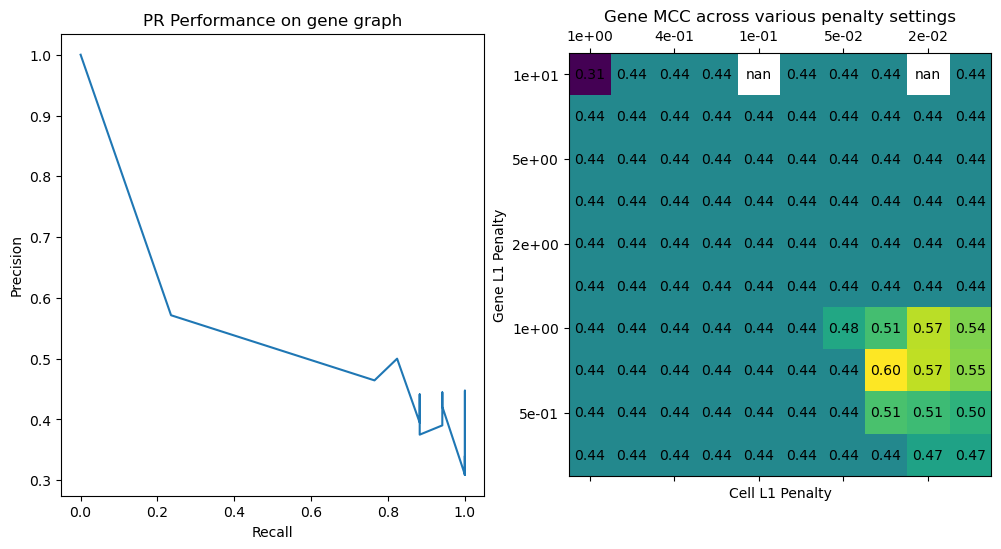

In [391]:
precs = []
reccs = []
f1s = []
mccs = []
for Lss in Ls_:
    genes = (Lss[1] - np.diag(np.diag(Lss[1]))) != 0
    prec = precision(true_graph, genes)
    recc = recall(true_graph, genes)
    precs.append(prec)
    reccs.append(recc)
    f1s.append(f1(true_graph, genes))
    mccs.append(mcc(true_graph, genes))

reccs = np.array(reccs)
idxs = np.argsort(reccs)
reccs = reccs[idxs]
precs = np.array(precs)[idxs]
mccs = np.array(mccs).reshape(len(gene_range), len(cell_range))

print(list(zip(precs, reccs)))

fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
ax1.plot(reccs, precs)
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.set_title("PR Performance on gene graph")

ax2.matshow(mccs)
ax2.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax2.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax2.set_xlabel("Cell L1 Penalty")
ax2.set_ylabel("Gene L1 Penalty")
ax2.set_title("Gene MCC across various penalty settings")

for i in range(mccs.shape[0]): # rows
    for j in range(mccs.shape[1]): # columns
        text = ax2.text(j, i, f"{mccs[i, j]:.2f}",
                       ha="center", va="center", color="black")

print(get_aupr(Ls_))

In [392]:
dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))

cell_range = np.logspace(-1, -4.5, 10)
gene_range = np.logspace(0.5, -2, 10)

glassoregs = [
    (y, x)
    for x in gene_range
    for y in cell_range
] # [3e-2, 1.5e0] is nice
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls_2, diagnostics = warm_start(
    ordered_krum.X,
    L_init=L_init,
    glassoregs = glassoregs,
    frobreg=frobreg,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    verbose=True
)

L1 Param: (np.float64(0.1), np.float64(3.1622776601683795))


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: (np.float64(0.04084238652674522), np.float64(3.1622776601683795))
L1 Param: (np.float64(0.016681005372000592), np.float64(3.1622776601683795))
L1 Param: (np.float64(0.006812920690579608), np.float64(3.1622776601683795))
L1 Param: (np.float64(0.0027825594022071257), np.float64(3.1622776601683795))
L1 Param: (np.float64(0.0011364636663857243), np.float64(3.1622776601683795))
L1 Param: (np.float64(0.00046415888336127773), np.float64(3.1622776601683795))
L1 Param: (np.float64(0.00018957356524063754), np.float64(3.1622776601683795))
L1 Param: (np.float64(7.742636826811278e-05), np.float64(3.1622776601683795))
L1 Param: (np.float64(3.1622776601683795e-05), np.float64(3.1622776601683795))
L1 Param: (np.float64(0.1), np.float64(1.6681005372000588))
L1 Param: (np.float64(0.04084238652674522), np.float64(1.6681005372000588))
L1 Param: (np.float64(0.016681005372000592), np.float64(1.6681005372000588))
L1 Param: (np.float64(0.006812920690579608), np.float64(1.6681005372000588))
L1 Param:

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3093877018.py:12: RuntimeWarning: divide by zero encountered in scalar divide
  return 2 / (1 / precision(true, pred) + 1 / recall(true, pred))
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3093877018.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (TP * TN - FP * FN) / np.sqrt(
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/2809126309.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/2809126309.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])


[(np.float64(1.0), np.float64(0.0)), (np.float64(1.0), np.float64(0.0)), (np.float64(1.0), np.float64(0.0)), (np.float64(0.0), np.float64(0.0)), (np.float64(0.6153846153846154), np.float64(0.47058823529411764)), (np.float64(0.4444444444444444), np.float64(0.7058823529411765)), (np.float64(0.5217391304347826), np.float64(0.7058823529411765)), (np.float64(0.52), np.float64(0.7647058823529411)), (np.float64(0.4482758620689655), np.float64(0.7647058823529411)), (np.float64(0.4642857142857143), np.float64(0.7647058823529411)), (np.float64(0.4117647058823529), np.float64(0.8235294117647058)), (np.float64(0.45161290322580644), np.float64(0.8235294117647058)), (np.float64(0.4), np.float64(0.8235294117647058)), (np.float64(0.36585365853658536), np.float64(0.8823529411764706)), (np.float64(0.36585365853658536), np.float64(0.8823529411764706)), (np.float64(0.38461538461538464), np.float64(0.8823529411764706)), (np.float64(0.40540540540540543), np.float64(0.8823529411764706)), (np.float64(0.384615

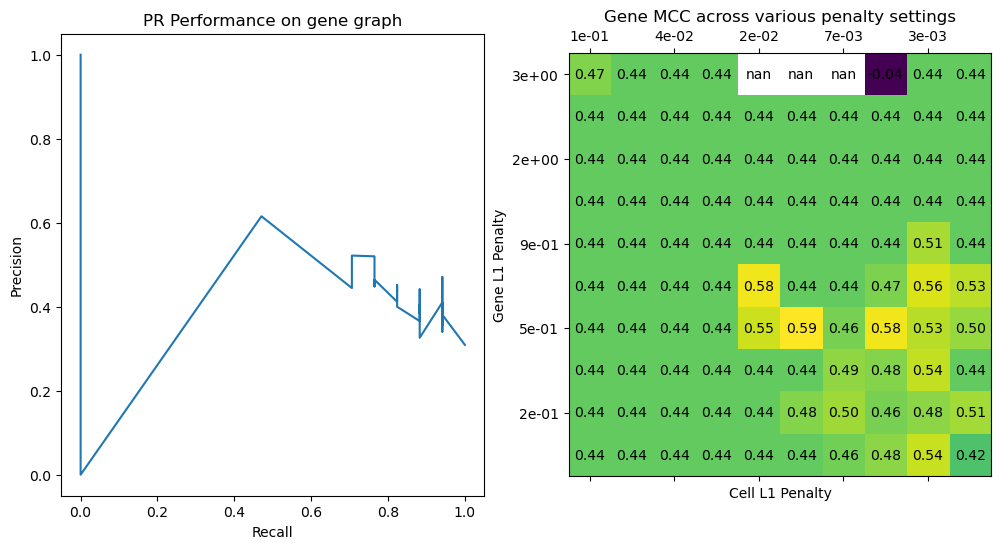

In [393]:
precs = []
reccs = []
f1s = []
mccs = []
for Lss in Ls_2:
    genes = (Lss[1] - np.diag(np.diag(Lss[1]))) != 0
    prec = precision(true_graph, genes)
    recc = recall(true_graph, genes)
    precs.append(prec)
    reccs.append(recc)
    f1s.append(f1(true_graph, genes))
    mccs.append(mcc(true_graph, genes))

reccs = np.array(reccs)
idxs = np.argsort(reccs)
reccs = reccs[idxs]
precs = np.array(precs)[idxs]
mccs = np.array(mccs).reshape(len(gene_range), len(cell_range))

print(list(zip(precs, reccs)))

fig, (ax1, ax2) = plt.subplots(figsize=(12, 6), ncols=2)
ax1.plot(reccs, precs)
ax1.set_xlabel("Recall")
ax1.set_ylabel("Precision")
ax1.set_title("PR Performance on gene graph")

ax2.matshow(mccs)
ax2.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax2.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax2.set_xlabel("Cell L1 Penalty")
ax2.set_ylabel("Gene L1 Penalty")
ax2.set_title("Gene MCC across various penalty settings")

for i in range(mccs.shape[0]): # rows
    for j in range(mccs.shape[1]): # columns
        text = ax2.text(j, i, f"{mccs[i, j]:.2f}",
                       ha="center", va="center", color="black")

print(get_aupr(Ls_2))

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/1749563810.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cells.vs["cell_type"] = ordered_krum.obs["cell_type"].cat.codes
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3093877018.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (TP * TN - FP * FN) / np.sqrt(
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/1749563810.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/1749563810.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. 

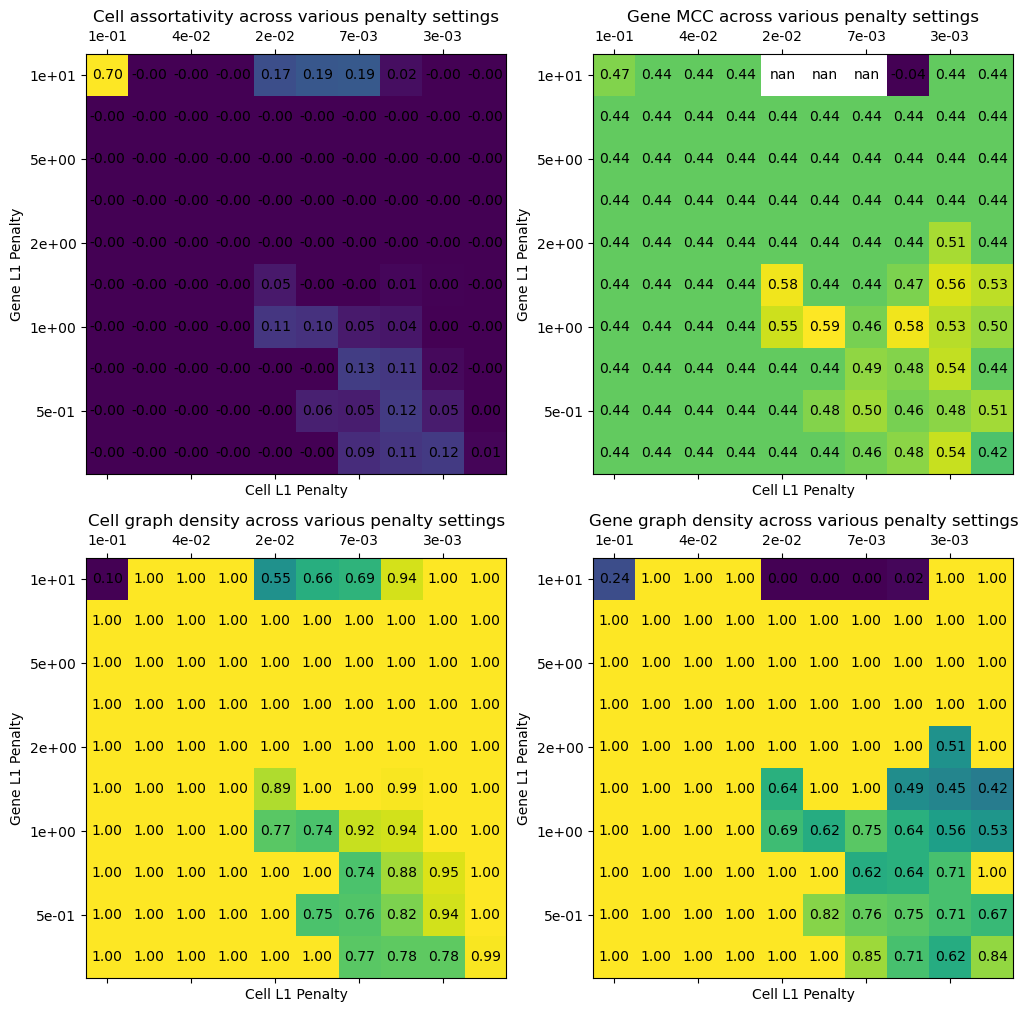

In [428]:
assorts = []
mccs = []
cell_sparsities = []
gene_sparsities = []
for Lss in Ls_2:
    # Get cell assortativity
    cells = ig.Graph.Weighted_Adjacency(Lss[0]).simplify()
    cells.vs["cell_type"] = ordered_krum.obs["cell_type"].cat.codes
    assorts.append(cells.assortativity(cells.vs["cell_type"]))

    # Get gene mcc
    genes = (Lss[1] - np.diag(np.diag(Lss[1]))) != 0
    mccs.append(mcc(true_graph, genes))

    # Sparsities
    cell_sparsities.append(2 * (np.tril(Lss[0], k=-1) != 0).sum() / (Lss[0].shape[0]**2 - Lss[0].shape[0]))
    gene_sparsities.append(2 * (np.tril(Lss[1], k=-1) != 0).sum() / (Lss[1].shape[0]**2 - Lss[1].shape[0]))
    

mccs = np.array(mccs).reshape(len(gene_range), len(cell_range))
assorts = np.array(assorts).reshape(len(gene_range), len(cell_range))
cell_sparsities = np.array(cell_sparsities).reshape(len(gene_range), len(cell_range))
gene_sparsities = np.array(gene_sparsities).reshape(len(gene_range), len(cell_range))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12, 12), ncols=2, nrows=2)
ax1.matshow(assorts)
ax1.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax1.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax1.set_xlabel("Cell L1 Penalty")
ax1.set_ylabel("Gene L1 Penalty")
ax1.set_title("Cell assortativity across various penalty settings")

for i in range(assorts.shape[0]): # rows
    for j in range(assorts.shape[1]): # columns
        text = ax1.text(j, i, f"{assorts[i, j]:.2f}",
                       ha="center", va="center", color="black")

ax2.matshow(mccs)
ax2.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax2.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax2.set_xlabel("Cell L1 Penalty")
ax2.set_ylabel("Gene L1 Penalty")
ax2.set_title("Gene MCC across various penalty settings")

for i in range(mccs.shape[0]): # rows
    for j in range(mccs.shape[1]): # columns
        text = ax2.text(j, i, f"{mccs[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
ax3.matshow(cell_sparsities)
ax3.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax3.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax3.set_xlabel("Cell L1 Penalty")
ax3.set_ylabel("Gene L1 Penalty")
ax3.set_title("Cell graph density across various penalty settings")

for i in range(cell_sparsities.shape[0]): # rows
    for j in range(cell_sparsities.shape[1]): # columns
        text = ax3.text(j, i, f"{cell_sparsities[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
ax4.matshow(gene_sparsities)
ax4.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax4.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax4.set_xlabel("Cell L1 Penalty")
ax4.set_ylabel("Gene L1 Penalty")
ax4.set_title("Gene graph density across various penalty settings")

for i in range(gene_sparsities.shape[0]): # rows
    for j in range(gene_sparsities.shape[1]): # columns
        text = ax4.text(j, i, f"{gene_sparsities[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
pass

In [429]:
dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))

cell_range = np.logspace(-1, -4.5, 10)
gene_range = np.logspace(1, -2, 10)

glassoregs = [
    (y, x)
    for x in gene_range
    for y in cell_range
] # [3e-2, 1.5e0] is nice
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls_3, diagnostics = warm_start(
    ordered_krum.X,
    L_init=L_init,
    glassoregs = glassoregs,
    frobreg=frobreg,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    verbose=True,
    dont_warm_start=True
)

L1 Param: (np.float64(0.1), np.float64(10.0))


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: (np.float64(0.04084238652674522), np.float64(10.0))
L1 Param: (np.float64(0.016681005372000592), np.float64(10.0))
L1 Param: (np.float64(0.006812920690579608), np.float64(10.0))
L1 Param: (np.float64(0.0027825594022071257), np.float64(10.0))
L1 Param: (np.float64(0.0011364636663857243), np.float64(10.0))
L1 Param: (np.float64(0.00046415888336127773), np.float64(10.0))
L1 Param: (np.float64(0.00018957356524063754), np.float64(10.0))
L1 Param: (np.float64(7.742636826811278e-05), np.float64(10.0))
L1 Param: (np.float64(3.1622776601683795e-05), np.float64(10.0))
L1 Param: (np.float64(0.1), np.float64(4.641588833612779))
L1 Param: (np.float64(0.04084238652674522), np.float64(4.641588833612779))
L1 Param: (np.float64(0.016681005372000592), np.float64(4.641588833612779))
L1 Param: (np.float64(0.006812920690579608), np.float64(4.641588833612779))
L1 Param: (np.float64(0.0027825594022071257), np.float64(4.641588833612779))
L1 Param: (np.float64(0.0011364636663857243), np.float64(4.641

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3978526534.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cells.vs["cell_type"] = ordered_krum.obs["cell_type"].cat.codes
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3093877018.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (TP * TN - FP * FN) / np.sqrt(
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3978526534.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3978526534.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. 

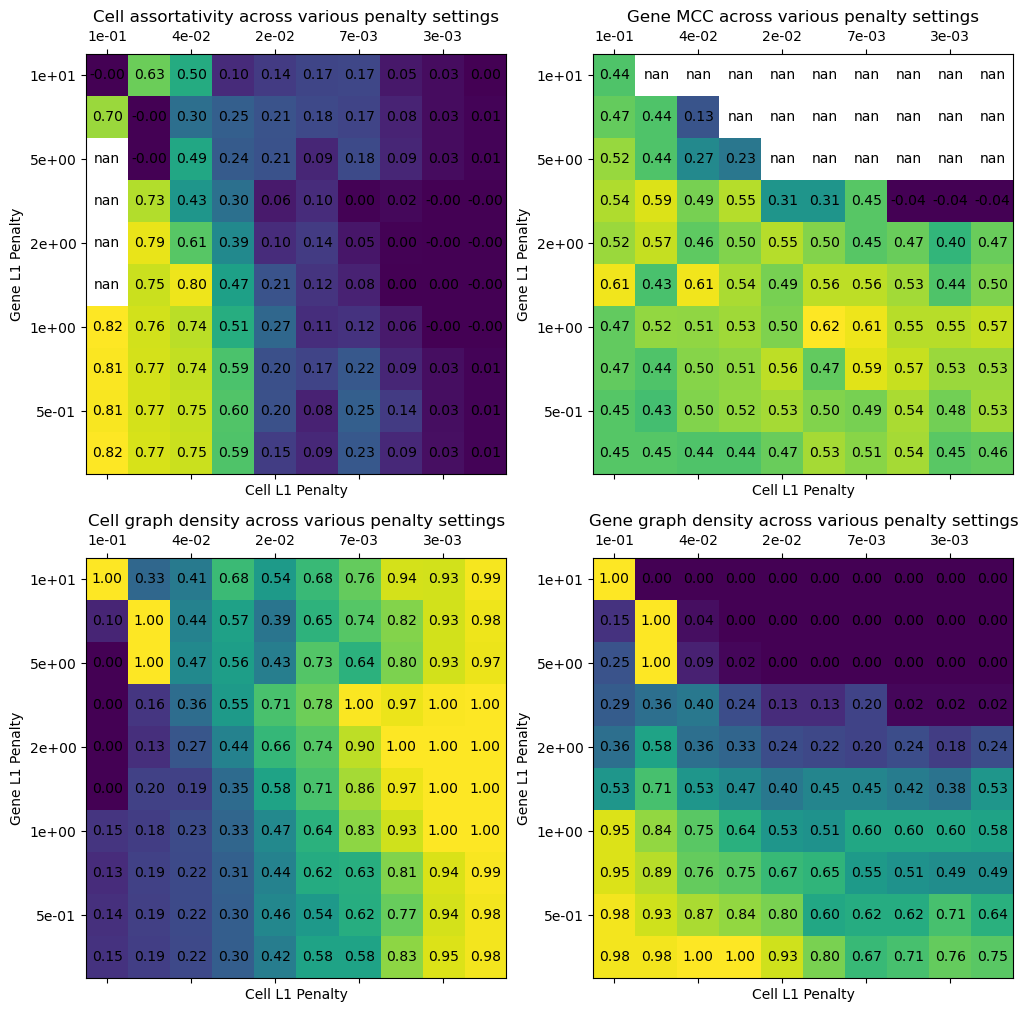

In [430]:
assorts = []
mccs = []
cell_sparsities = []
gene_sparsities = []
for Lss in Ls_3:
    # Get cell assortativity
    cells = ig.Graph.Weighted_Adjacency(Lss[0]).simplify()
    cells.vs["cell_type"] = ordered_krum.obs["cell_type"].cat.codes
    assorts.append(cells.assortativity(cells.vs["cell_type"]))

    # Get gene mcc
    genes = (Lss[1] - np.diag(np.diag(Lss[1]))) != 0
    mccs.append(mcc(true_graph, genes))

    # Sparsities
    cell_sparsities.append(2 * (np.tril(Lss[0], k=-1) != 0).sum() / (Lss[0].shape[0]**2 - Lss[0].shape[0]))
    gene_sparsities.append(2 * (np.tril(Lss[1], k=-1) != 0).sum() / (Lss[1].shape[0]**2 - Lss[1].shape[0]))
    

mccs = np.array(mccs).reshape(len(gene_range), len(cell_range))
assorts = np.array(assorts).reshape(len(gene_range), len(cell_range))
cell_sparsities = np.array(cell_sparsities).reshape(len(gene_range), len(cell_range))
gene_sparsities = np.array(gene_sparsities).reshape(len(gene_range), len(cell_range))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12, 12), ncols=2, nrows=2)
ax1.matshow(assorts)
ax1.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax1.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax1.set_xlabel("Cell L1 Penalty")
ax1.set_ylabel("Gene L1 Penalty")
ax1.set_title("Cell assortativity across various penalty settings")

for i in range(assorts.shape[0]): # rows
    for j in range(assorts.shape[1]): # columns
        text = ax1.text(j, i, f"{assorts[i, j]:.2f}",
                       ha="center", va="center", color="black")

ax2.matshow(mccs)
ax2.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax2.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax2.set_xlabel("Cell L1 Penalty")
ax2.set_ylabel("Gene L1 Penalty")
ax2.set_title("Gene MCC across various penalty settings")

for i in range(mccs.shape[0]): # rows
    for j in range(mccs.shape[1]): # columns
        text = ax2.text(j, i, f"{mccs[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
ax3.matshow(cell_sparsities)
ax3.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax3.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax3.set_xlabel("Cell L1 Penalty")
ax3.set_ylabel("Gene L1 Penalty")
ax3.set_title("Cell graph density across various penalty settings")

for i in range(cell_sparsities.shape[0]): # rows
    for j in range(cell_sparsities.shape[1]): # columns
        text = ax3.text(j, i, f"{cell_sparsities[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
ax4.matshow(gene_sparsities)
ax4.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax4.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax4.set_xlabel("Cell L1 Penalty")
ax4.set_ylabel("Gene L1 Penalty")
ax4.set_title("Gene graph density across various penalty settings")

for i in range(gene_sparsities.shape[0]): # rows
    for j in range(gene_sparsities.shape[1]): # columns
        text = ax4.text(j, i, f"{gene_sparsities[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
pass

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3978526534.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cells.vs["cell_type"] = ordered_krum.obs["cell_type"].cat.codes
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3093877018.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (TP * TN - FP * FN) / np.sqrt(
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3978526534.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3978526534.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. 

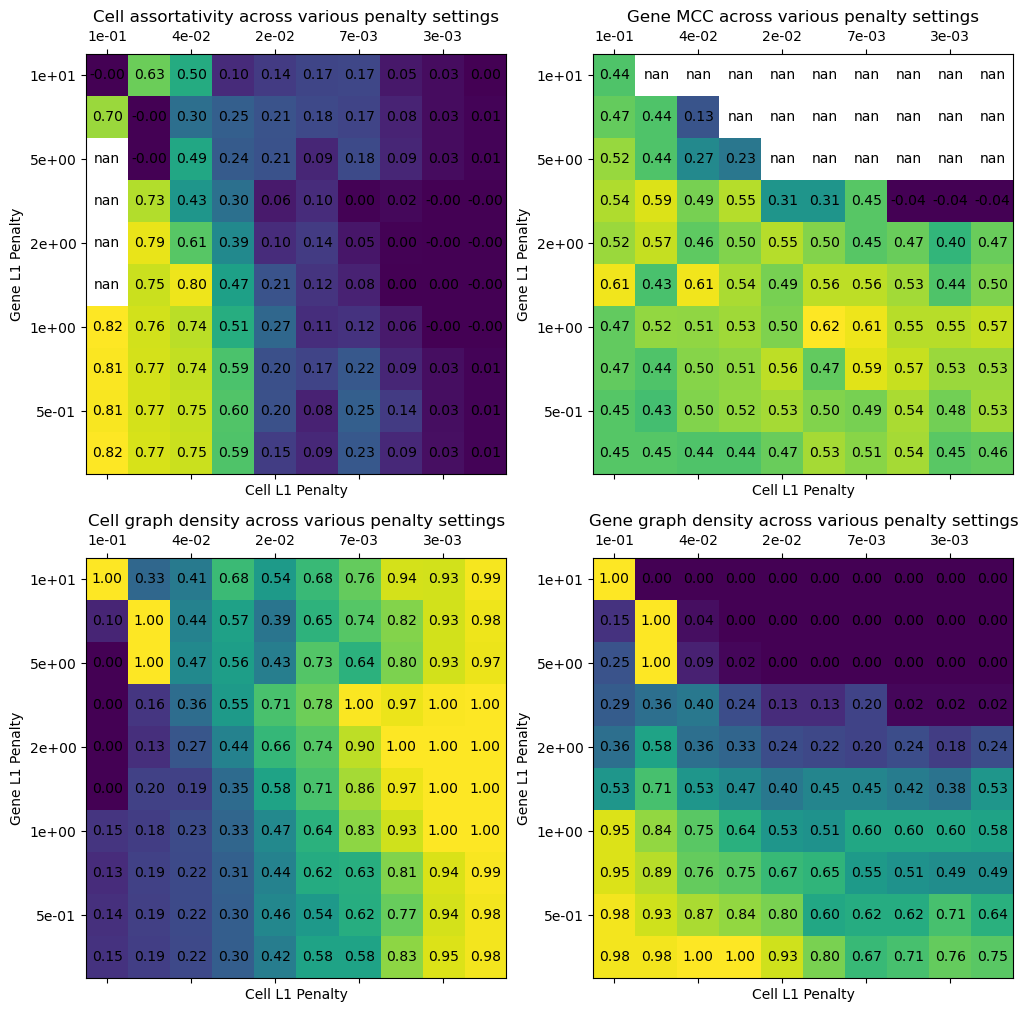

In [433]:
assorts = []
mccs = []
cell_sparsities = []
gene_sparsities = []
for Lss in Ls_3:
    # Get cell assortativity
    cells = ig.Graph.Weighted_Adjacency(Lss[0]).simplify()
    cells.vs["cell_type"] = ordered_krum.obs["cell_type"].cat.codes
    assorts.append(cells.assortativity(cells.vs["cell_type"]))

    # Get gene mcc
    genes = (Lss[1] - np.diag(np.diag(Lss[1]))) != 0
    mccs.append(mcc(true_graph, genes))

    # Sparsities
    cell_sparsities.append(2 * (np.tril(Lss[0], k=-1) != 0).sum() / (Lss[0].shape[0]**2 - Lss[0].shape[0]))
    gene_sparsities.append(2 * (np.tril(Lss[1], k=-1) != 0).sum() / (Lss[1].shape[0]**2 - Lss[1].shape[0]))
    

mccs = np.array(mccs).reshape(len(gene_range), len(cell_range))
assorts = np.array(assorts).reshape(len(gene_range), len(cell_range))
cell_sparsities = np.array(cell_sparsities).reshape(len(gene_range), len(cell_range))
gene_sparsities = np.array(gene_sparsities).reshape(len(gene_range), len(cell_range))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12, 12), ncols=2, nrows=2)
ax1.matshow(assorts)
ax1.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax1.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax1.set_xlabel("Cell L1 Penalty")
ax1.set_ylabel("Gene L1 Penalty")
ax1.set_title("Cell assortativity across various penalty settings")

for i in range(assorts.shape[0]): # rows
    for j in range(assorts.shape[1]): # columns
        text = ax1.text(j, i, f"{assorts[i, j]:.2f}",
                       ha="center", va="center", color="black")

ax2.matshow(mccs)
ax2.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax2.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax2.set_xlabel("Cell L1 Penalty")
ax2.set_ylabel("Gene L1 Penalty")
ax2.set_title("Gene MCC across various penalty settings")

for i in range(mccs.shape[0]): # rows
    for j in range(mccs.shape[1]): # columns
        text = ax2.text(j, i, f"{mccs[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
ax3.matshow(cell_sparsities)
ax3.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax3.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax3.set_xlabel("Cell L1 Penalty")
ax3.set_ylabel("Gene L1 Penalty")
ax3.set_title("Cell graph density across various penalty settings")

for i in range(cell_sparsities.shape[0]): # rows
    for j in range(cell_sparsities.shape[1]): # columns
        text = ax3.text(j, i, f"{cell_sparsities[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
ax4.matshow(gene_sparsities)
ax4.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax4.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax4.set_xlabel("Cell L1 Penalty")
ax4.set_ylabel("Gene L1 Penalty")
ax4.set_title("Gene graph density across various penalty settings")

for i in range(gene_sparsities.shape[0]): # rows
    for j in range(gene_sparsities.shape[1]): # columns
        text = ax4.text(j, i, f"{gene_sparsities[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
pass

In [436]:
dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))

cell_range = np.logspace(-0.5, -4.5, 10)
gene_range = np.logspace(1, -2, 10)

glassoregs = [
    (y, x)
    for x in gene_range
    for y in cell_range
] # [3e-2, 1.5e0] is nice
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls_4, diagnostics = warm_start(
    ordered_krum.X,
    L_init=L_init,
    glassoregs = glassoregs,
    frobreg=frobreg,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10,
    verbose=True,
    dont_warm_start=True
)

L1 Param: (np.float64(0.31622776601683794), np.float64(10.0))


/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


L1 Param: (np.float64(0.11364636663857249), np.float64(10.0))
L1 Param: (np.float64(0.04084238652674522), np.float64(10.0))
L1 Param: (np.float64(0.014677992676220698), np.float64(10.0))
L1 Param: (np.float64(0.00527499706370262), np.float64(10.0))
L1 Param: (np.float64(0.0018957356524063754), np.float64(10.0))
L1 Param: (np.float64(0.0006812920690579615), np.float64(10.0))
L1 Param: (np.float64(0.0002448436746822229), np.float64(10.0))
L1 Param: (np.float64(8.799225435691074e-05), np.float64(10.0))
L1 Param: (np.float64(3.1622776601683795e-05), np.float64(10.0))
L1 Param: (np.float64(0.31622776601683794), np.float64(4.641588833612779))
L1 Param: (np.float64(0.11364636663857249), np.float64(4.641588833612779))
L1 Param: (np.float64(0.04084238652674522), np.float64(4.641588833612779))
L1 Param: (np.float64(0.014677992676220698), np.float64(4.641588833612779))
L1 Param: (np.float64(0.00527499706370262), np.float64(4.641588833612779))
L1 Param: (np.float64(0.0018957356524063754), np.float

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3255862038.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cells.vs["cell_type"] = ordered_krum.obs["cell_type"].cat.codes
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3093877018.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (TP * TN - FP * FN) / np.sqrt(
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3255862038.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3255862038.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. 

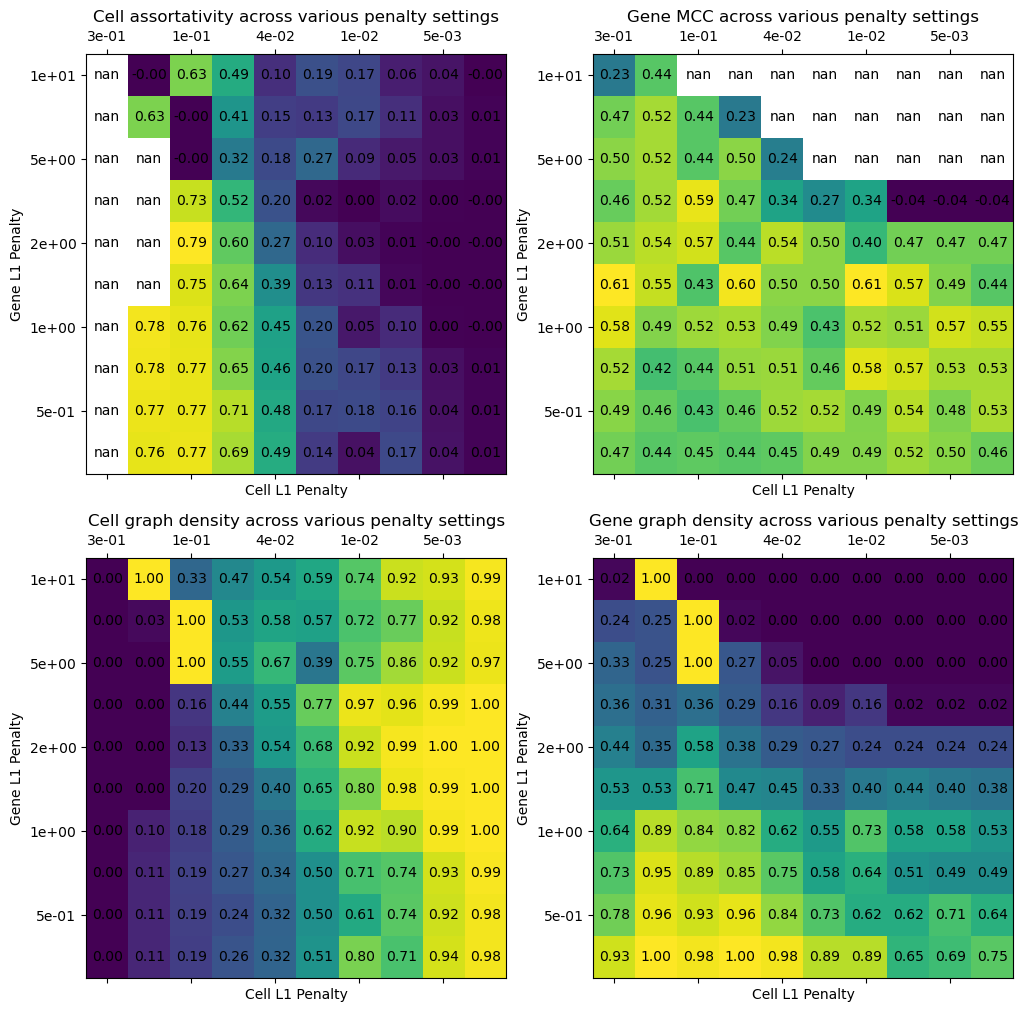

In [437]:
assorts = []
mccs = []
cell_sparsities = []
gene_sparsities = []
for Lss in Ls_4:
    # Get cell assortativity
    cells = ig.Graph.Weighted_Adjacency(Lss[0]).simplify()
    cells.vs["cell_type"] = ordered_krum.obs["cell_type"].cat.codes
    assorts.append(cells.assortativity(cells.vs["cell_type"]))

    # Get gene mcc
    genes = (Lss[1] - np.diag(np.diag(Lss[1]))) != 0
    mccs.append(mcc(true_graph, genes))

    # Sparsities
    cell_sparsities.append(2 * (np.tril(Lss[0], k=-1) != 0).sum() / (Lss[0].shape[0]**2 - Lss[0].shape[0]))
    gene_sparsities.append(2 * (np.tril(Lss[1], k=-1) != 0).sum() / (Lss[1].shape[0]**2 - Lss[1].shape[0]))
    

mccs = np.array(mccs).reshape(len(gene_range), len(cell_range))
assorts = np.array(assorts).reshape(len(gene_range), len(cell_range))
cell_sparsities = np.array(cell_sparsities).reshape(len(gene_range), len(cell_range))
gene_sparsities = np.array(gene_sparsities).reshape(len(gene_range), len(cell_range))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12, 12), ncols=2, nrows=2)
ax1.matshow(assorts)
ax1.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax1.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax1.set_xlabel("Cell L1 Penalty")
ax1.set_ylabel("Gene L1 Penalty")
ax1.set_title("Cell assortativity across various penalty settings")

for i in range(assorts.shape[0]): # rows
    for j in range(assorts.shape[1]): # columns
        text = ax1.text(j, i, f"{assorts[i, j]:.2f}",
                       ha="center", va="center", color="black")

ax2.matshow(mccs)
ax2.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax2.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax2.set_xlabel("Cell L1 Penalty")
ax2.set_ylabel("Gene L1 Penalty")
ax2.set_title("Gene MCC across various penalty settings")

for i in range(mccs.shape[0]): # rows
    for j in range(mccs.shape[1]): # columns
        text = ax2.text(j, i, f"{mccs[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
ax3.matshow(cell_sparsities)
ax3.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax3.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax3.set_xlabel("Cell L1 Penalty")
ax3.set_ylabel("Gene L1 Penalty")
ax3.set_title("Cell graph density across various penalty settings")

for i in range(cell_sparsities.shape[0]): # rows
    for j in range(cell_sparsities.shape[1]): # columns
        text = ax3.text(j, i, f"{cell_sparsities[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
ax4.matshow(gene_sparsities)
ax4.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax4.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax4.set_xlabel("Cell L1 Penalty")
ax4.set_ylabel("Gene L1 Penalty")
ax4.set_title("Gene graph density across various penalty settings")

for i in range(gene_sparsities.shape[0]): # rows
    for j in range(gene_sparsities.shape[1]): # columns
        text = ax4.text(j, i, f"{gene_sparsities[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
pass

/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3951482390.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cells.vs["cell_type"] = ordered_krum.obs["cell_type"].cat.codes
/var/folders/k0/qy74mdx10qs493700g929k5h0000gn/T/ipykernel_6257/3093877018.py:20: RuntimeWarning: invalid value encountered in scalar divide
  return (TP * TN - FP * FN) / np.sqrt(


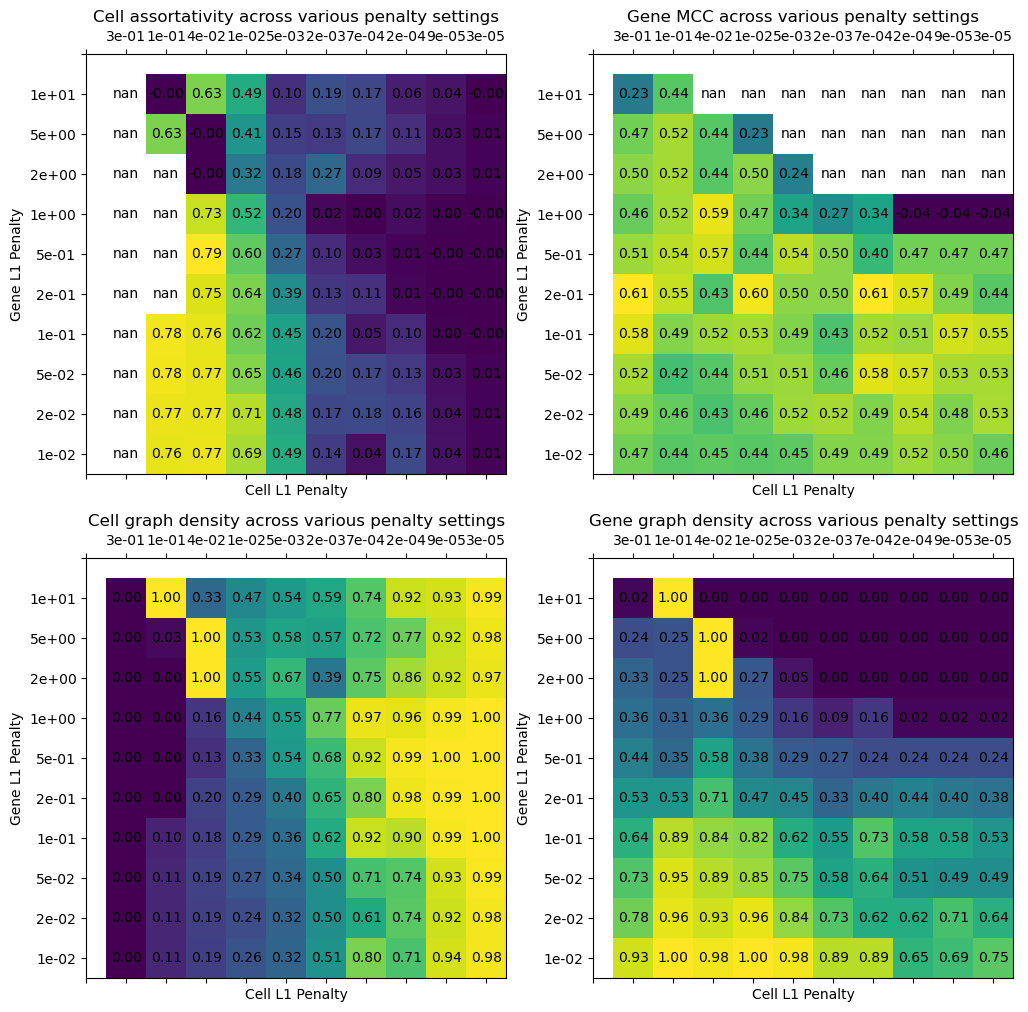

In [ ]:
assorts = []
mccs = []
cell_sparsities = []
gene_sparsities = []
for Lss in Ls_4:
    # Get cell assortativity
    cells = ig.Graph.Weighted_Adjacency(Lss[0]).simplify()
    cells.vs["cell_type"] = ordered_krum.obs["cell_type"].cat.codes
    assorts.append(cells.assortativity(cells.vs["cell_type"]))

    # Get gene mcc
    genes = (Lss[1] - np.diag(np.diag(Lss[1]))) != 0
    mccs.append(mcc(true_graph, genes))

    # Sparsities
    cell_sparsities.append(2 * (np.tril(Lss[0], k=-1) != 0).sum() / (Lss[0].shape[0]**2 - Lss[0].shape[0]))
    gene_sparsities.append(2 * (np.tril(Lss[1], k=-1) != 0).sum() / (Lss[1].shape[0]**2 - Lss[1].shape[0]))
    

mccs = np.array(mccs).reshape(len(gene_range), len(cell_range))
assorts = np.array(assorts).reshape(len(gene_range), len(cell_range))
cell_sparsities = np.array(cell_sparsities).reshape(len(gene_range), len(cell_range))
gene_sparsities = np.array(gene_sparsities).reshape(len(gene_range), len(cell_range))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12, 12), ncols=2, nrows=2)
ax1.matshow(assorts)
ax1.set_xticks(np.arange(11)-1)
ax1.set_yticks(np.arange(11)-1)
ax1.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax1.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax1.set_xlabel("Cell L1 Penalty")
ax1.set_ylabel("Gene L1 Penalty")
ax1.set_title("Cell assortativity across various penalty settings")

for i in range(assorts.shape[0]): # rows
    for j in range(assorts.shape[1]): # columns
        text = ax1.text(j, i, f"{assorts[i, j]:.2f}",
                       ha="center", va="center", color="black")

ax2.matshow(mccs)
ax2.set_xticks(np.arange(11)-1)
ax2.set_yticks(np.arange(11)-1)
ax2.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax2.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax2.set_xlabel("Cell L1 Penalty")
ax2.set_ylabel("Gene L1 Penalty")
ax2.set_title("Gene MCC across various penalty settings")

for i in range(mccs.shape[0]): # rows
    for j in range(mccs.shape[1]): # columns
        text = ax2.text(j, i, f"{mccs[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
ax3.matshow(cell_sparsities)
ax3.set_xticks(np.arange(11)-1)
ax3.set_yticks(np.arange(11)-1)
ax3.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax3.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax3.set_xlabel("Cell L1 Penalty")
ax3.set_ylabel("Gene L1 Penalty")
ax3.set_title("Cell graph density across various penalty settings")

for i in range(cell_sparsities.shape[0]): # rows
    for j in range(cell_sparsities.shape[1]): # columns
        text = ax3.text(j, i, f"{cell_sparsities[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
ax4.matshow(gene_sparsities)
ax4.set_xticks(np.arange(11)-1)
ax4.set_yticks(np.arange(11)-1)
ax4.set_xticklabels([''] + [f'{x:.0e}' for x in cell_range])
ax4.set_yticklabels([''] + [f'{x:.0e}' for x in gene_range])
ax4.set_xlabel("Cell L1 Penalty")
ax4.set_ylabel("Gene L1 Penalty")
ax4.set_title("Gene graph density across various penalty settings")

for i in range(gene_sparsities.shape[0]): # rows
    for j in range(gene_sparsities.shape[1]): # columns
        text = ax4.text(j, i, f"{gene_sparsities[i, j]:.2f}",
                       ha="center", va="center", color="black")
        
pass

In [522]:
best_cellreg, best_genereg = glassoregs[56]
print(glassoregs[56])
mccs.reshape(-1)[56]

(np.float64(0.0006812920690579615), np.float64(0.21544346900318845))


np.float64(0.6110111212133171)

In [523]:
dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = [best_cellreg, best_genereg]
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls_best, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


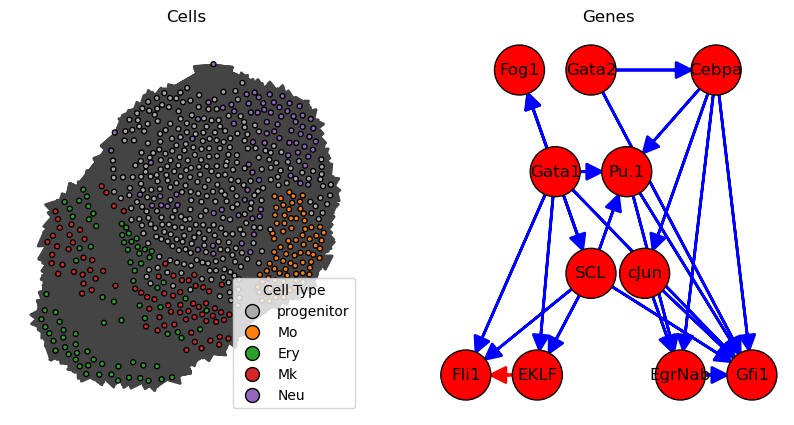

In [524]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

# Must transpose - convention in iGraph is that i -> j, whereas with LGAM It's j -> i
cell_graph = ig.Graph.Weighted_Adjacency(Ls_best[0].T - np.diag(np.diag(Ls_best[0])))
cell_types = ordered_krum.obs['cell_type']
type_to_color = {ctype: ordered_krum.uns['cell_type_colors'][i % len(ordered_krum.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
#cell_graph.vs["edge_color"] = cell_graph.vs["color"]
#cell_graph.es["color"] = ['red' if w > 0 else 'blue' for w in cell_graph.es["weight"]]

random.seed(0)
cell_layout = cell_graph.layout(layout='auto')

gene_graph = ig.Graph.Weighted_Adjacency(Ls_best[1].T - np.diag(np.diag(Ls_best[1])))
gene_graph.vs["label"] = ordered_krum.var_names
gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5,
    layout=cell_layout
)
ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Cells")
ax2.set_title("Genes")

# Add legend
# Extract colors and labels
colors = ordered_krum.uns['cell_type_colors']
labels = ordered_krum.obs['cell_type'].unique()

# Build legend handles
handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=color, markersize=10, label=label)
    for label, color in zip(labels, colors)
]
ax1.legend(handles=handles, title='Cell Type', loc='lower right')

pass

In [525]:
glassoregs[53]

(np.float64(0.014677992676220698), np.float64(0.21544346900318845))

In [526]:
best_cellreg, best_genereg = glassoregs[53]

dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = [best_cellreg, best_genereg]
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls_best2, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


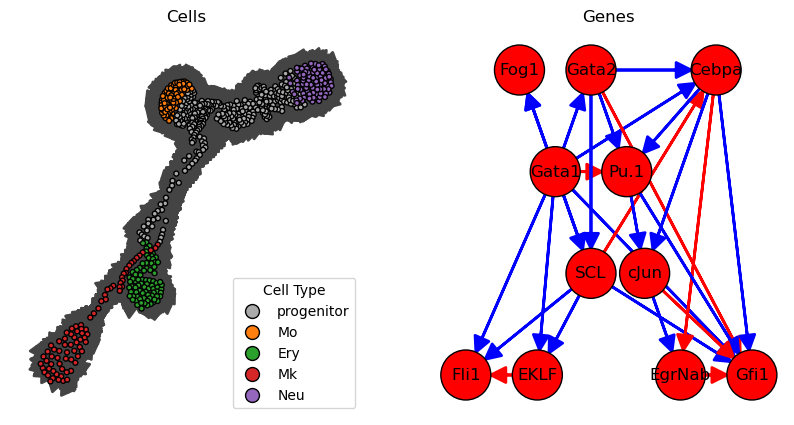

In [527]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

# Must transpose - convention in iGraph is that i -> j, whereas with LGAM It's j -> i
cell_graph = ig.Graph.Weighted_Adjacency(Ls_best2[0].T - np.diag(np.diag(Ls_best2[0])))
cell_types = ordered_krum.obs['cell_type']
type_to_color = {ctype: ordered_krum.uns['cell_type_colors'][i % len(ordered_krum.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
#cell_graph.vs["edge_color"] = cell_graph.vs["color"]
#cell_graph.es["color"] = ['red' if w > 0 else 'blue' for w in cell_graph.es["weight"]]

random.seed(0)
cell_layout = cell_graph.layout(layout='auto')

gene_graph = ig.Graph.Weighted_Adjacency(Ls_best2[1].T - np.diag(np.diag(Ls_best2[1])))
gene_graph.vs["label"] = ordered_krum.var_names
gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5,
    layout=cell_layout
)
ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Cells")
ax2.set_title("Genes")

# Add legend
# Extract colors and labels
colors = ordered_krum.uns['cell_type_colors']
labels = ordered_krum.obs['cell_type'].unique()

# Build legend handles
handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=color, markersize=10, label=label)
    for label, color in zip(labels, colors)
]
ax1.legend(handles=handles, title='Cell Type', loc='lower right')

pass

In [528]:
glassoregs[50]

(np.float64(0.31622776601683794), np.float64(0.21544346900318845))

In [529]:
best_cellreg, best_genereg = glassoregs[50]

dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = [best_cellreg, best_genereg]
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls_best3, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


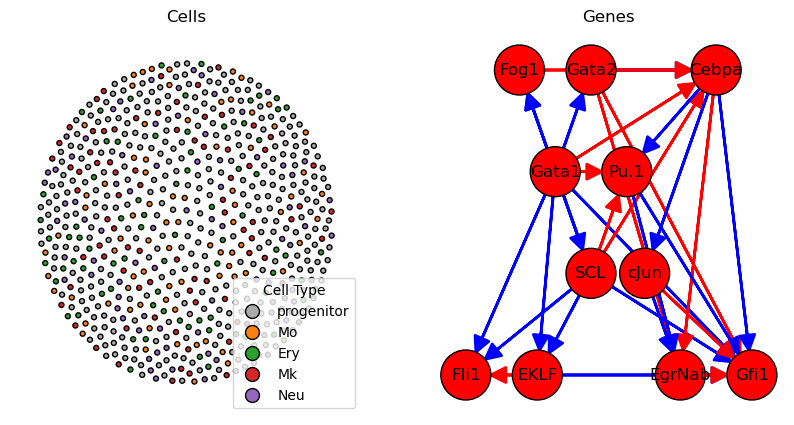

In [530]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

# Must transpose - convention in iGraph is that i -> j, whereas with LGAM It's j -> i
cell_graph = ig.Graph.Weighted_Adjacency(Ls_best3[0].T - np.diag(np.diag(Ls_best3[0])))
cell_types = ordered_krum.obs['cell_type']
type_to_color = {ctype: ordered_krum.uns['cell_type_colors'][i % len(ordered_krum.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
#cell_graph.vs["edge_color"] = cell_graph.vs["color"]
#cell_graph.es["color"] = ['red' if w > 0 else 'blue' for w in cell_graph.es["weight"]]

random.seed(0)
cell_layout = cell_graph.layout(layout='auto')

gene_graph = ig.Graph.Weighted_Adjacency(Ls_best3[1].T - np.diag(np.diag(Ls_best3[1])))
gene_graph.vs["label"] = ordered_krum.var_names
gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5,
    layout=cell_layout
)
ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Cells")
ax2.set_title("Genes")

# Add legend
# Extract colors and labels
colors = ordered_krum.uns['cell_type_colors']
labels = ordered_krum.obs['cell_type'].unique()

# Build legend handles
handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=color, markersize=10, label=label)
    for label, color in zip(labels, colors)
]
ax1.legend(handles=handles, title='Cell Type', loc='lower right')

pass

In [531]:
best_cellreg, best_genereg = glassoregs[32]

dataset = ordered_krum.X
dataset /= dataset.sum(axis=1).reshape(-1, 1)
dims = dataset.shape
L_init = [np.eye(d) for d in dims]

frobreg = 1/np.prod(dims)**(1/len(dims))
glassoreg = [best_cellreg, best_genereg]
objective, gradient, proximal = get_optimizer_oracles(dataset, frobreg=frobreg, glassoregs=glassoreg)

Ls_best4, (_, eps, _, _) = proximal_accelerated_gradient(
    f=objective,
    del_f=gradient,
    prox=proximal,
    P=project_to_lower_with_positive_diag,
    Ls=L_init,
    mu=0.2,
    init_alpha=1,
    tau=0.5,
    beta=0.0001,
    max_iter=1000,
    tol=1e-10
)

/Users/baileyandrew/Cartesian-LGAM/proximal_gradient_descent.py:43: UserWarning: Alpha too small, stopping line search
  warnings.warn("Alpha too small, stopping line search")


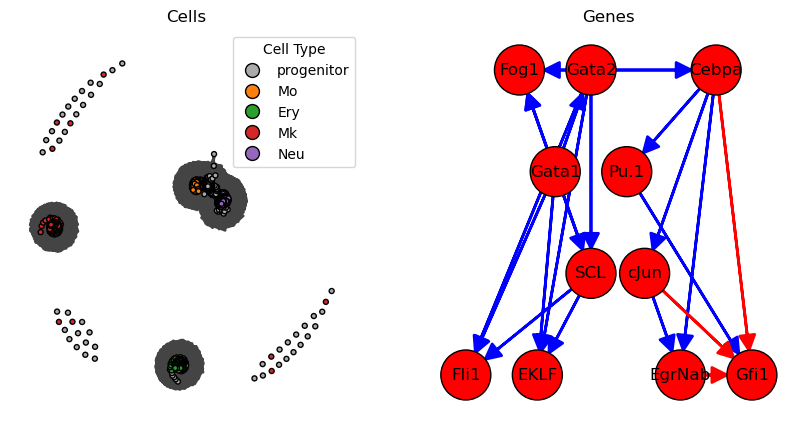

In [533]:
# It'll take a couple seconds to draw this graph.
fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

# Must transpose - convention in iGraph is that i -> j, whereas with LGAM It's j -> i
cell_graph = ig.Graph.Weighted_Adjacency(Ls_best4[0].T - np.diag(np.diag(Ls_best4[0])))
cell_types = ordered_krum.obs['cell_type']
type_to_color = {ctype: ordered_krum.uns['cell_type_colors'][i % len(ordered_krum.uns['cell_type_colors'])] for i, ctype in enumerate(cell_types.unique())}
cell_graph.vs["color"] = cell_types.map(type_to_color).tolist()
#cell_graph.vs["edge_color"] = cell_graph.vs["color"]
#cell_graph.es["color"] = ['red' if w > 0 else 'blue' for w in cell_graph.es["weight"]]

random.seed(0)
cell_layout = cell_graph.layout(layout='auto')

gene_graph = ig.Graph.Weighted_Adjacency(Ls_best4[1].T - np.diag(np.diag(Ls_best4[1])))
gene_graph.vs["label"] = ordered_krum.var_names
gene_graph.es["color"] = ['red' if w > 0 else 'blue' for w in gene_graph.es["weight"]]

ig.plot(
    cell_graph,
    target=ax1,
    vertex_size=5,
    layout=cell_layout
)
ig.plot(
    gene_graph,
    target=ax2,
    vertex_size=50,
    layout=gene_layout
)

ax1.set_title("Cells")
ax2.set_title("Genes")

# Add legend
# Extract colors and labels
colors = ordered_krum.uns['cell_type_colors']
labels = ordered_krum.obs['cell_type'].unique()

# Build legend handles
handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=color, markersize=10, label=label)
    for label, color in zip(labels, colors)
]
ax1.legend(handles=handles, title='Cell Type', loc='upper right')

pass